# Predicción de readmisión de pacientes con diabetes

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


## Carga de Dataset

Este dataset, obtenido de [UCI ML Repository](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). El dataset abarca diez años de registros médicos en múltiples hospitales de EE.UU., centrados en pacientes diabéticos y su posible readmisión hospitalaria. El objetivo es predecir si un paciente será readmitido en menos de 30 días, en más de 30 días, o si no requerirá readmisión a corto plazo, lo cual permite mejorar la atención que reciben los pacientes una vez que ingresan por primera vez, evitando altas erróneas.

Cargamos el dataset. El na_values indica que se interprete el ? como NaN, ya que los datos iriginales mezcla el NaN con el ? para indicar valores faltantes.

In [98]:

df = pd.read_csv("data/diabetic_data.csv",na_values='?')


/var/folders/rz/rwdts9855175trx5l6s0n6380000gp/T/ipykernel_1295/821533217.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/diabetic_data.csv",na_values='?')


El aviso nos dice que la columna 10 tiene valores mezclados, de ? con otros valores en la misma columna, algo esperable.

## Preprocesado de datos

Miramos el dataset:

In [99]:
print(df.shape)
df[:20]


(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),NaN,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [100]:
a=df.shape
df.columns,print(a)

(101766, 50)


(Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
        'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'time_in_hospital', 'payer_code', 'medical_specialty',
        'num_lab_procedures', 'num_procedures', 'num_medications',
        'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
        'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
        'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
        'tolazamide', 'examide', 'citoglipton', 'insulin',
        'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
        'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
       dtype='object'),
 None)

Eliminamos las dos primeras columnas, pues mirando la documentación, son valores unicos sobre el ingreso de los clientes. Además, también eliminamos 'payer_code', que indica cómo pago el seguro médico del cliente:

In [101]:
df.drop(['encounter_id','patient_nbr','payer_code'],axis=1,inplace=True)

Vemos cuántos valores faltan y en qué columnas:

In [102]:
df.isnull().sum()

race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

Segun la instruccion de arriba, faltan valores en 9 de las 50 columnas. Vemos qué porcentaje de todos los datos faltan en cada columna:

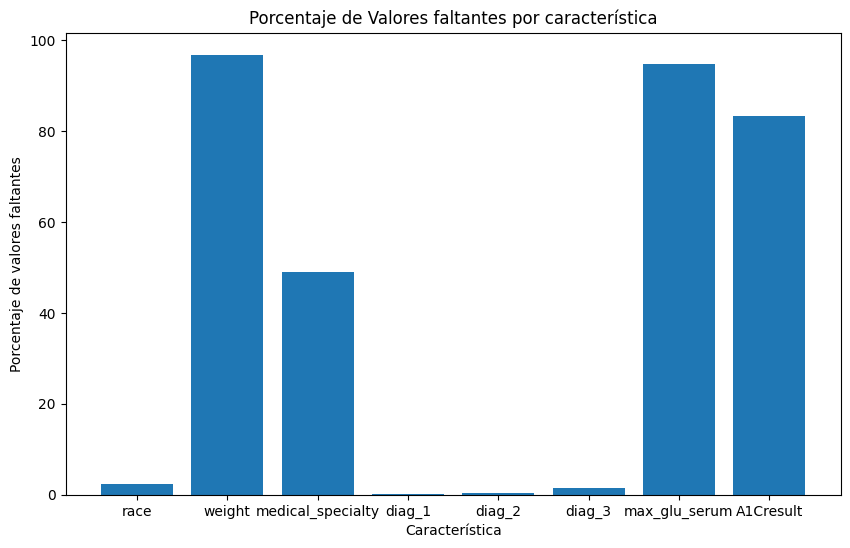

In [103]:
porcentajes=[]
columnas=[]

for columna in df.columns:
    b=df[columna].isnull().sum()
    if b > 0:
        porcentaje=b / df.shape[0]*100
        porcentajes.append(porcentaje)
        columnas.append(columna)

plt.figure(figsize=(10, 6))
plt.bar(columnas,porcentajes)
plt.xlabel('Característica')
plt.ylabel('Porcentaje de valores faltantes')
plt.title('Porcentaje de Valores faltantes por característica')
plt.show()

En las columnas en las que faltan pocos datos (hasta un 50%), reemplazaremos estos valores faltantes. Otras, como weight, max_glu_serum y A1Cresult serán eliminadas directamente, pues faltan la mayoría de sus valores, con lo que la representatividad de esa columna es muy baja, y hacer una imputación es complicado (podríamos añadir ruido y perjudicar el rendimiento). Aunque valores variables como el peso sean importantes al hablar de diabetes, no tenemos datos suficientes para tenerlos en cuenta. 

In [104]:
df.drop(["weight","max_glu_serum","A1Cresult"],axis=1,inplace=True)

Para las columnas donde faltan muy pocos datos, eliminamos las instancias donde faltan, porque, además de ser datos de tipo categórico (con lo que no se puede usar métodos estadísticos, solo la moda) no se afecta significativamente al tamaño del conjunto y además evitamos añadir cualquier sesgo que se pueda introducir al imputar, quedándonos solo con instancias reales y completas.

In [105]:
columnas_borra_instancia=['race','diag_1','diag_2','diag_3']

indices_eliminar=[]
for i in range(df.shape[0]):
    fila = df.iloc[i]
    if any(pd.isnull(fila[columna]) for columna in columnas_borra_instancia):
        indices_eliminar.append(i)

df.drop(indices_eliminar,inplace=True)

Si vemos el archivo (data/IDS_mapping.csv) los siguientes valores no son relevantes en la columna 'discharge_disposition_id':

In [106]:

valores_a_eliminar = [11, 18, 19, 20, 21, 25, 26]

df = df[~df['discharge_disposition_id'].isin(valores_a_eliminar)]

df.reset_index(drop=True, inplace=True)


Vemos ahora qué variables nos queda con datos faltantes:

In [107]:
for column in df.columns:
    b=df[column].isnull().sum()
    if b>0:
        print(column, b/df.shape[0]*100)


medical_specialty 48.53709508881923


Ya solo nos queda tratar con medical speciality, que tiene valores categóricos.

In [108]:
df[['medical_specialty']].dtypes

medical_specialty    object
dtype: object

Antes de tratarla e imputar sus valores, pues no puedo eliminarlos al faltar un 50% y además es importante pues indica de qué especialidad es el médico que trata al paciente en primera instancia, vamos a estudiar cómo sustituir en el df los valores categóricos por numéricos, para así poder después entrenar a los modelos.

### Sustitucion categoricos por numericos

Vemos qué tipo de datos tiene cada variable:

In [109]:
df.dtypes

race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone       

Primero vemos si hay hay variables categoricas ordinales, y asi asignarle un valor numerico, o si hay variables binarias, y asignarle 0 y 1. También, vemos cómo en las siguientes columnas hay muy pocos valores categoricos, siendo la mayoría numéricos:


In [110]:
df['diag_1'].value_counts(),df['diag_2'].value_counts(),df['diag_3'].value_counts()

(diag_1
 428    6233
 414    5861
 786    3641
 486    3195
 410    3115
        ... 
 385       1
 347       1
 634       1
 375       1
 V51       1
 Name: count, Length: 709, dtype: int64,
 diag_2
 276     6218
 428     6014
 250     5097
 427     4586
 401     3402
         ... 
 E929       1
 52         1
 990        1
 974        1
 927        1
 Name: count, Length: 733, dtype: int64,
 diag_3
 250    10525
 401     7570
 276     4816
 428     4174
 427     3582
        ...  
 992        1
 657        1
 684        1
 603        1
 971        1
 Name: count, Length: 780, dtype: int64)

Se ve que en estas columnas hay valores que empiezan por letras, más concretamente en E y V:

In [111]:
diag1 = df[df['diag_1'].str.startswith(('V', 'E'))]['diag_1']
diag2 = df[df['diag_2'].str.startswith(('V', 'E'))]['diag_2']
diag3 = df[df['diag_3'].str.startswith(('V', 'E'))]['diag_3']

diag1.value_counts().sum(),diag2.value_counts().sum(),diag3.value_counts().sum()

(1456, 2333, 4720)

Es decir, de las 98000 filas, solo tienen estos valores categoricos un numero muy bajo. Estas letras y números se enmarcan en el [Código ICD9](https://es.wikipedia.org/wiki/CIE-9), un sistema de codificación utilizado para clasificar enfermedades y procedimientos médicos. Aunque podríamos eliminar esas instancias, vamos a probar a hacer un one-hot. 

In [112]:
df_oh_prueba = pd.get_dummies(df, columns=['diag_1', 'diag_2', 'diag_3'], dtype=int)
df_oh_prueba.shape,a

((91872, 2263), (101766, 50))

Como vemos, esto es inviable, pues hemos aumentado la dimensionalidad en mas de 2000 variables. La solucion que queda es eliminar las instancias con V y E, lo que no afecta mucho al conjunto pues son pocas instancias las que tienen estos codigos que empiezan por letras. Así, estas variables pasarán a ser numéricas:

In [113]:
df = df[~df['diag_1'].str.startswith(('V', 'E'))]
df = df[~df['diag_2'].str.startswith(('V', 'E'))]
df = df[~df['diag_3'].str.startswith(('V', 'E'))]

df['diag_1'] = df['diag_1'].astype('float')
df['diag_2'] = df['diag_2'].astype('float')
df['diag_3'] = df['diag_3'].astype('float')

A la variable 'gender' le asignamos valores binarios

In [114]:
df['gender'].value_counts()

gender
Female             45402
Male               38684
Unknown/Invalid        1
Name: count, dtype: int64

In [115]:
df.loc[df['gender'] == 'Male', 'gender'] = 0
df.loc[df['gender'] != 0, 'gender'] = 1

In [116]:
df['gender'].value_counts()

gender
1    45403
0    38684
Name: count, dtype: int64

Seguimos explorando y vemos como hay varias columnas categóricas pero ordinales en este caso. Las siguientes columnas son medicinas recetadas a estos pacientes. Sus posibles valores son:

- up: si la dosis se aumentó durante la consulta.
- down: si la dosis se disminuyó durante la consulta.
- steady: si la dosis no cambió durante la consulta.
- no: si el medicamento no fue recetado.

por lo que un orden lógico parece:

- up: 3
- steady: 2
- down: 1
- no: 0


In [117]:
for columna in df.columns[18:-3]:
    print(df[columna].value_counts())

metformin
No        67518
Steady    15242
Up          862
Down        465
Name: count, dtype: int64
repaglinide
No        82696
Steady     1253
Up           99
Down         39
Name: count, dtype: int64
nateglinide
No        83463
Steady      598
Up           16
Down         10
Name: count, dtype: int64
chlorpropamide
No        84031
Steady       51
Up            4
Down          1
Name: count, dtype: int64
glimepiride
No        79612
Steady     4043
Up          269
Down        163
Name: count, dtype: int64
acetohexamide
No        84086
Steady        1
Name: count, dtype: int64
glipizide
No        73316
Steady     9639
Up          657
Down        475
Name: count, dtype: int64
glyburide
No        75640
Steady     7357
Up          642
Down        448
Name: count, dtype: int64
tolbutamide
No        84069
Steady       18
Name: count, dtype: int64
pioglitazone
No        77880
Steady     5917
Up          197
Down         93
Name: count, dtype: int64
rosiglitazone
No        78710
Steady     516

In [118]:
df.iloc[:,18:-3]=df.iloc[:,18:-3].replace({'No': 0, 'Up': 3, 'Down':1, 'Steady':2})

Vemos ahora qué ocurre con las ultimas dos variables:

In [119]:
df['change'].value_counts(),df['diabetesMed'].value_counts()

(change
 No    44444
 Ch    39643
 Name: count, dtype: int64,
 diabetesMed
 Yes    65299
 No     18788
 Name: count, dtype: int64)

Como vemos son binarios, sustituimos por 0 y 1:

In [120]:
df.iloc[:,[-3,-2]]=df.iloc[:,[-3,-2]].replace({'No': 0, 'Ch': 1, 'Yes':1})

Ya solo no queda age, race y medical specialty (esta aun con NaN) con valores categoricos:

In [121]:
df['age'].value_counts(),df['race'].value_counts(),df['medical_specialty'].value_counts()

(age
 [70-80)     21535
 [60-70)     18713
 [80-90)     14427
 [50-60)     14354
 [40-50)      7981
 [30-40)      3068
 [90-100)     2356
 [20-30)      1239
 [10-20)       363
 [0-10)         51
 Name: count, dtype: int64,
 race
 Caucasian          64428
 AfricanAmerican    16120
 Hispanic            1704
 Other               1277
 Asian                558
 Name: count, dtype: int64,
 medical_specialty
 InternalMedicine                    12524
 Emergency/Trauma                     6949
 Family/GeneralPractice               6091
 Cardiology                           4629
 Surgery-General                      2553
                                     ...  
 Perinatology                            1
 Neurophysiology                         1
 SportsMedicine                          1
 Psychiatry-Addictive                    1
 Surgery-PlasticwithinHeadandNeck        1
 Name: count, Length: 71, dtype: int64)

Podemos verlo en un gráfico para las dos primeras

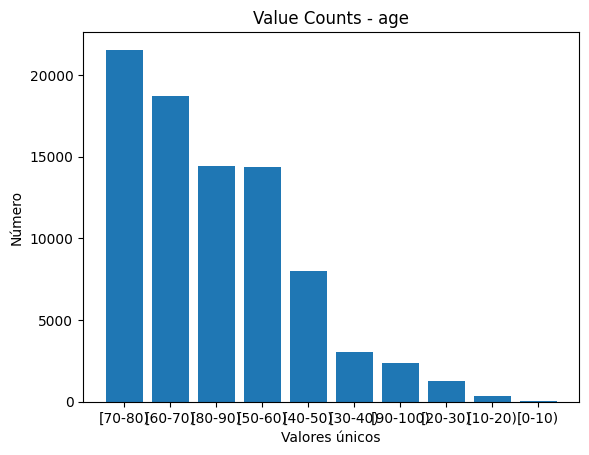

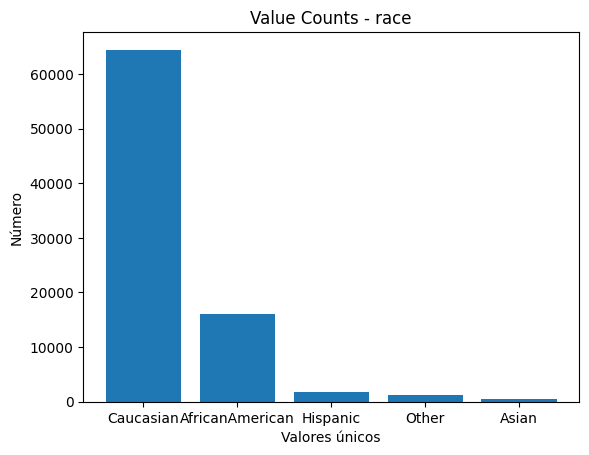

In [122]:
plt.figure()
plt.bar(df['age'].value_counts().index, df['age'].value_counts().values)
plt.xlabel('Valores únicos')
plt.ylabel('Número')
plt.title('Value Counts - age')

plt.figure()
plt.bar(df['race'].value_counts().index, df['race'].value_counts().values)
plt.xlabel('Valores únicos')
plt.ylabel('Número')
plt.title('Value Counts - race')



plt.show()

Como vemos, el ingreso es mayoritario de personas mayores, y de raza caucásico (aunque esto debe ser normalizado a la población de los lugares de los hospitales). Puede haber dudas de si la raza es una variable importante o representativa, de momento vamos a considerarla y no la eliminaremos.

En la primera, 'age', tenemos una ordinalidad clara, por tanto sutituimos:

In [123]:
df['age']=df['age'].replace({'[0-10)':10,'[10-20)':20,'[20-30)':30,'[30-40)':40,'[40-50)':50,'[50-60)':60,'[60-70)':70,'[70-80)':80,'[80-90)':90,'[90-100)':100})

En la segunda, 'race', al no haber ninguna ordinalidad, y no ser binaria, la pasaremos a one hot. La de medical specialty la trataremos más adelante, ya que aún faltan valores.

In [124]:
df = pd.get_dummies(df, columns=['race'],dtype=int)

Así hemos convertido los datos categoricos a numericos, intentando no disparar la dimensionalidad, por eso no se ha realizado el one hot desde el principio, si no se ha estudiado qué valores había en cada columna. De haber ejecutado el one hot de primeras, la dimensionalidad se habría multiplicado por miles, lo cual es inmanejable. Finalmente, entre columnas eliminadas (-6) y one-hot (+4), hemos reducido la dimensionalidad en 2 variables, lo cual es bueno.

In [125]:
print("Dimensión inicial: {}".format(a))
print("Dimensión actual: {}".format(df.shape))

Dimensión inicial: (101766, 50)
Dimensión actual: (84087, 48)


### Imputación por moda de valores categóricos

En la unica columna que queda con valores categoricos, vamos a imputar según la moda de la columna:

In [126]:
df1=df.copy()
y=df1.pop('readmitted')
X=df1

In [127]:
X['medical_specialty'].fillna(X['medical_specialty'].mode()[0] , inplace=True) 

Ahora no tendríamos ningún valor faltante en nuestros datos. Lo siguiente es tratar con los valores categoricos de la columna medical_specialty, pues son los unicos que nos quedan.

In [128]:
X['medical_specialty'].unique(),len(X['medical_specialty'].unique())

(array(['InternalMedicine', 'Family/GeneralPractice', 'Cardiology',
        'Surgery-General', 'Orthopedics', 'Gastroenterology', 'Nephrology',
        'Psychiatry', 'Orthopedics-Reconstructive', 'Pulmonology',
        'Surgery-Neuro', 'Obsterics&Gynecology-GynecologicOnco',
        'Endocrinology', 'Urology', 'Radiology', 'ObstetricsandGynecology',
        'Pediatrics', 'Pediatrics-Hematology-Oncology',
        'Surgery-Cardiovascular/Thoracic', 'Emergency/Trauma',
        'Pediatrics-CriticalCare', 'Neurology', 'Pediatrics-Endocrinology',
        'Hematology/Oncology', 'Psychiatry-Child/Adolescent',
        'Surgery-Colon&Rectal', 'Podiatry', 'Pediatrics-Pulmonology',
        'Anesthesiology-Pediatric', 'Gynecology', 'Pediatrics-Neurology',
        'Surgery-Plastic', 'Surgery-Thoracic',
        'Surgery-PlasticwithinHeadandNeck', 'Psychology', 'Ophthalmology',
        'Surgery-Pediatric', 'Otolaryngology', 'InfectiousDiseases',
        'PhysicalMedicineandRehabilitation', 'Anesthesio

### Ordinaldiad y One-Hot

Como vemos, tenemos 71 posibles valores para esta columna. Ahora tenemos dos opciones: transformarlos en numéricos directamente, introduciendo una ordinalidad ficticia, o hacer one-hot. Probaremos las dos formas, y veremos si hay diferencias significativas entre usar una u otra.

In [129]:
X_oh = pd.get_dummies(X, columns=['medical_specialty'],dtype=int)
X_oh.shape
print("La dimensionalidad ha aumentado de {} a {}.".format(df.shape[1],X_oh.shape[1]))

La dimensionalidad ha aumentado de 48 a 117.


Como vemos, es un aumento significativo pero dentro de unos valores normales, considerando también el número de ejemplos.

In [130]:
X_ord=X.copy()

In [131]:
for i, valor in enumerate(X_ord['medical_specialty'].unique()):
    X_ord['medical_specialty'] = X_ord['medical_specialty'].replace(valor, i)

In [132]:
X_ord.shape

(84087, 47)

De esta forma no aumentamos dimensionalidad pero introducimos ordinalidad que no había en la columna. Por ultimo codificamos la variable objetivo. Esta variable objetivo indica si un paciente ha tenido que reingresar antes de los 30 dias posteriores al alta (<30), despues de los 30 dias posteriores al alta (>30) o no ha tenido que ser reingresado. Un orden lógico sería:

- NO: 0
- '>'30: 1
- <30: 2

In [133]:
y.unique()

array(['>30', 'NO', '<30'], dtype=object)

In [134]:
y= y.replace({'>30': 1, 'NO': 0, '<30':2})

Como conlusión, tengo datos numericos (X_oh y X ord) con su variable objetivo correspondiente y, que es la misma para los dos. Ahora, para trabajar mas comodo, pasaré todos los datos, que ya son numericos, a tipo float y reordenamos los índices.

In [135]:
X_ord=X_ord.astype(float)
X_oh=X_oh.astype(float)

X_ord.reset_index(drop=True, inplace=True),X_oh.reset_index(drop=True, inplace=True),y.reset_index(drop=True, inplace=True)

(None, None, None)

Por último, voy a escalar los datos a media 0 y desviación estandar 1:

In [136]:
scaler = StandardScaler()

scaler.fit(X_ord)
X_ord= pd.DataFrame(scaler.transform(X_ord),columns=X_ord.columns)

scaler.fit(X_oh)
X_oh= pd.DataFrame(scaler.transform(X_oh),columns=X_oh.columns)


## Visualizacion gráfica y selección de características

### Boxplots

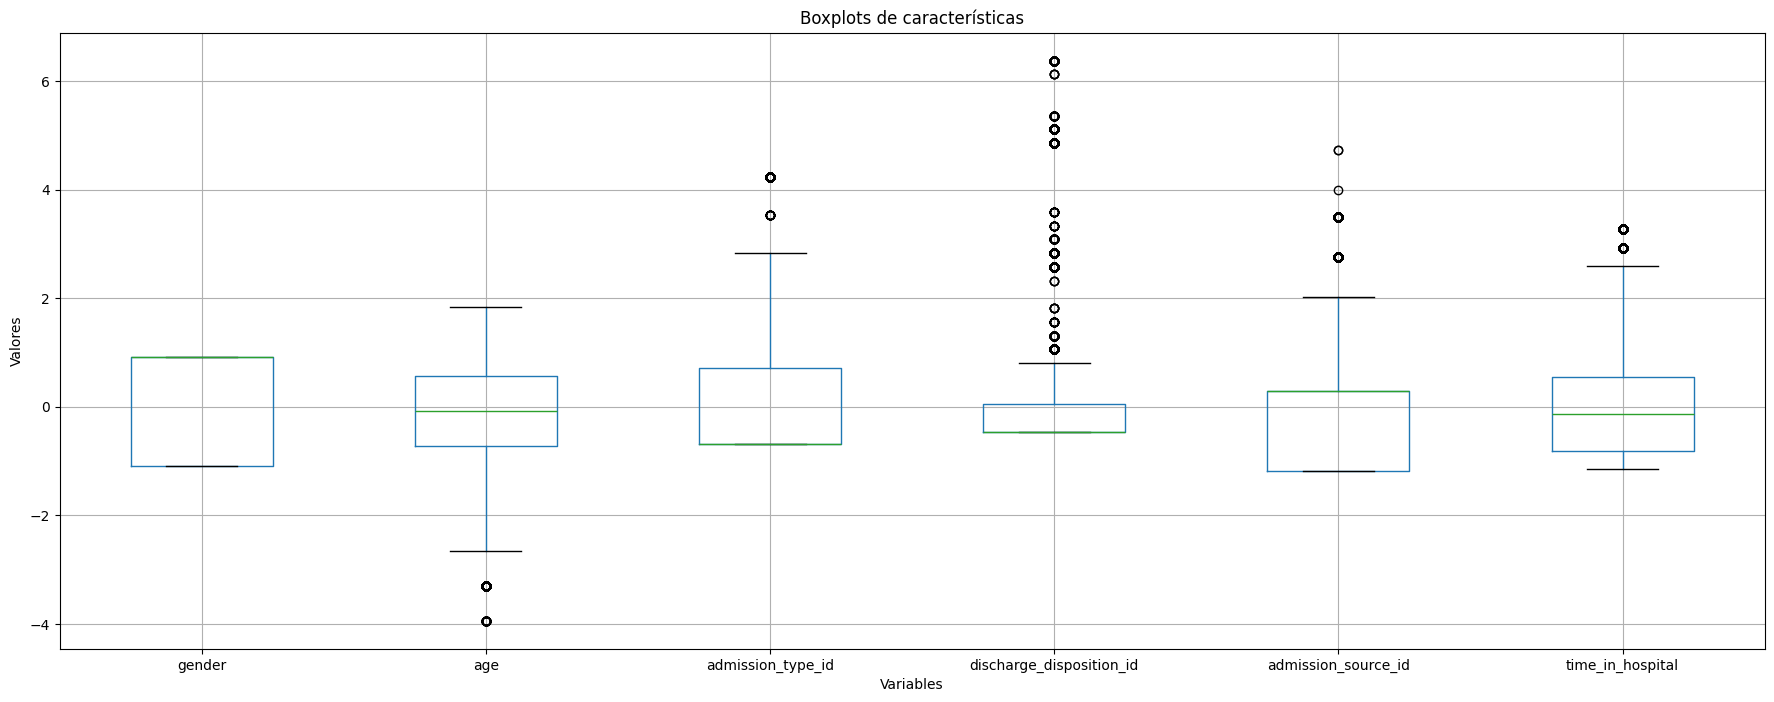

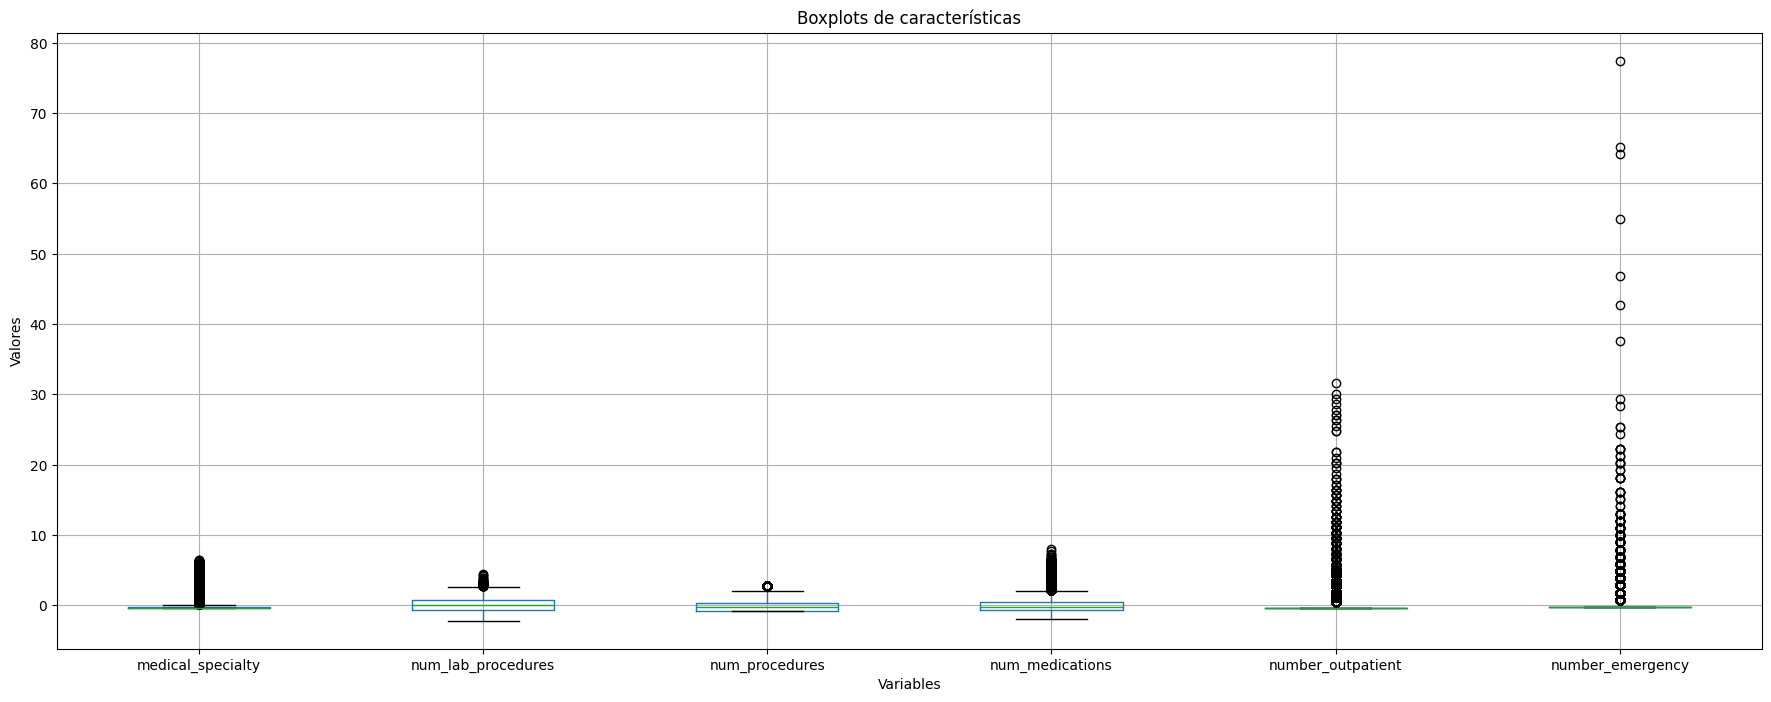

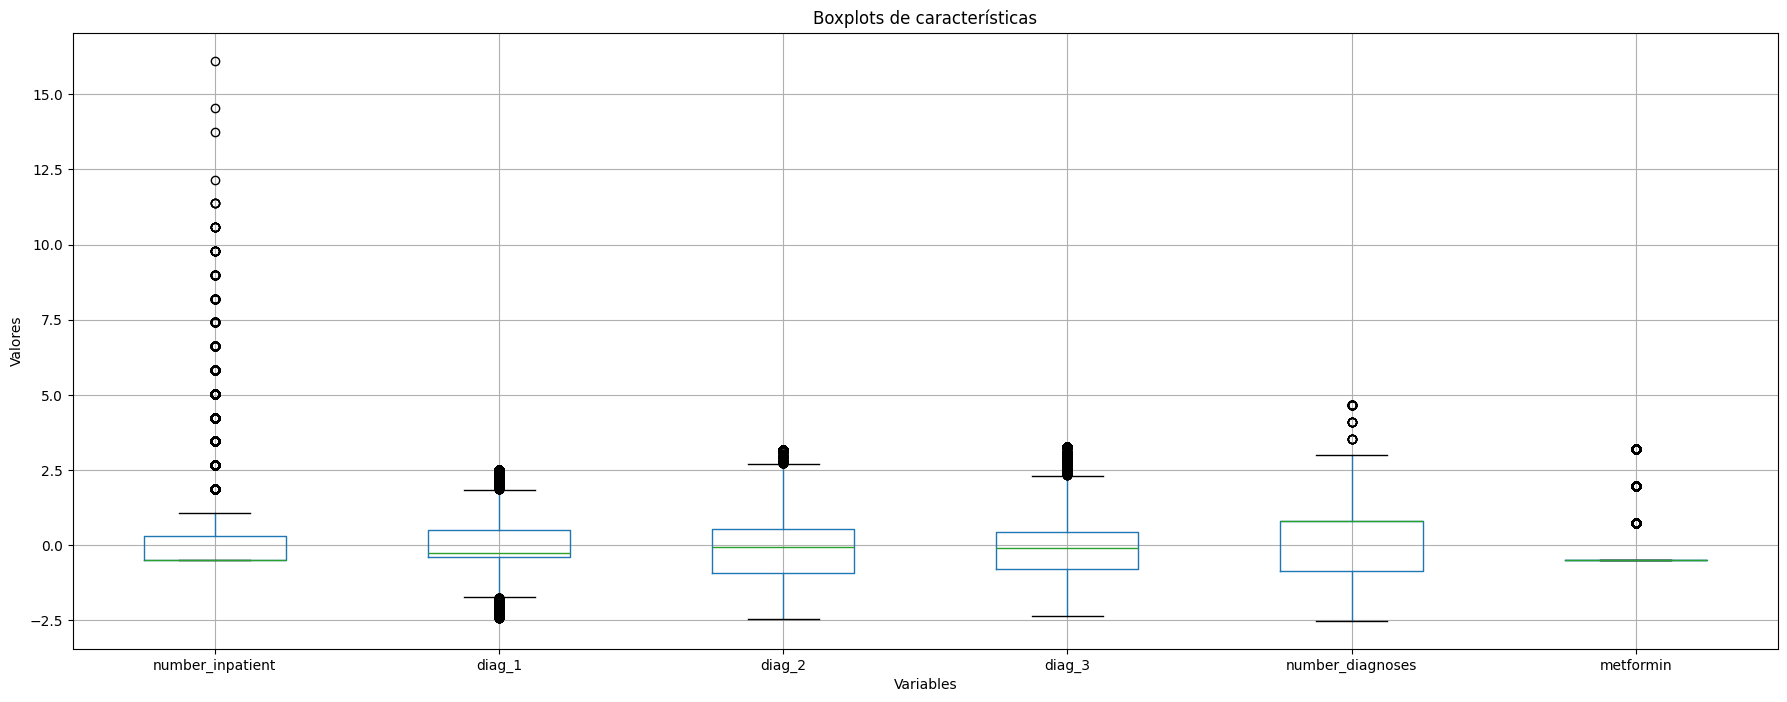

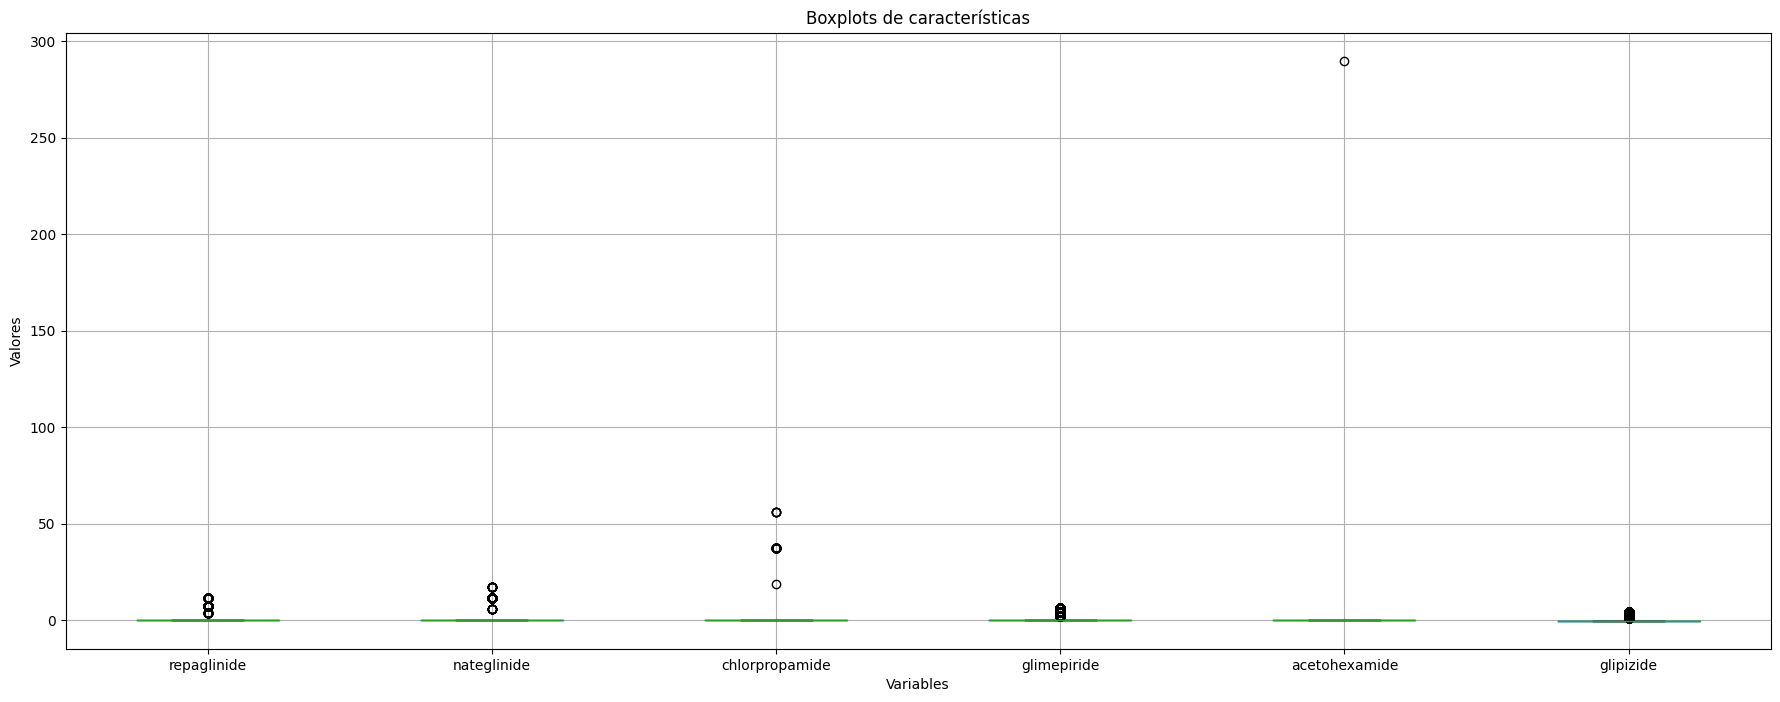

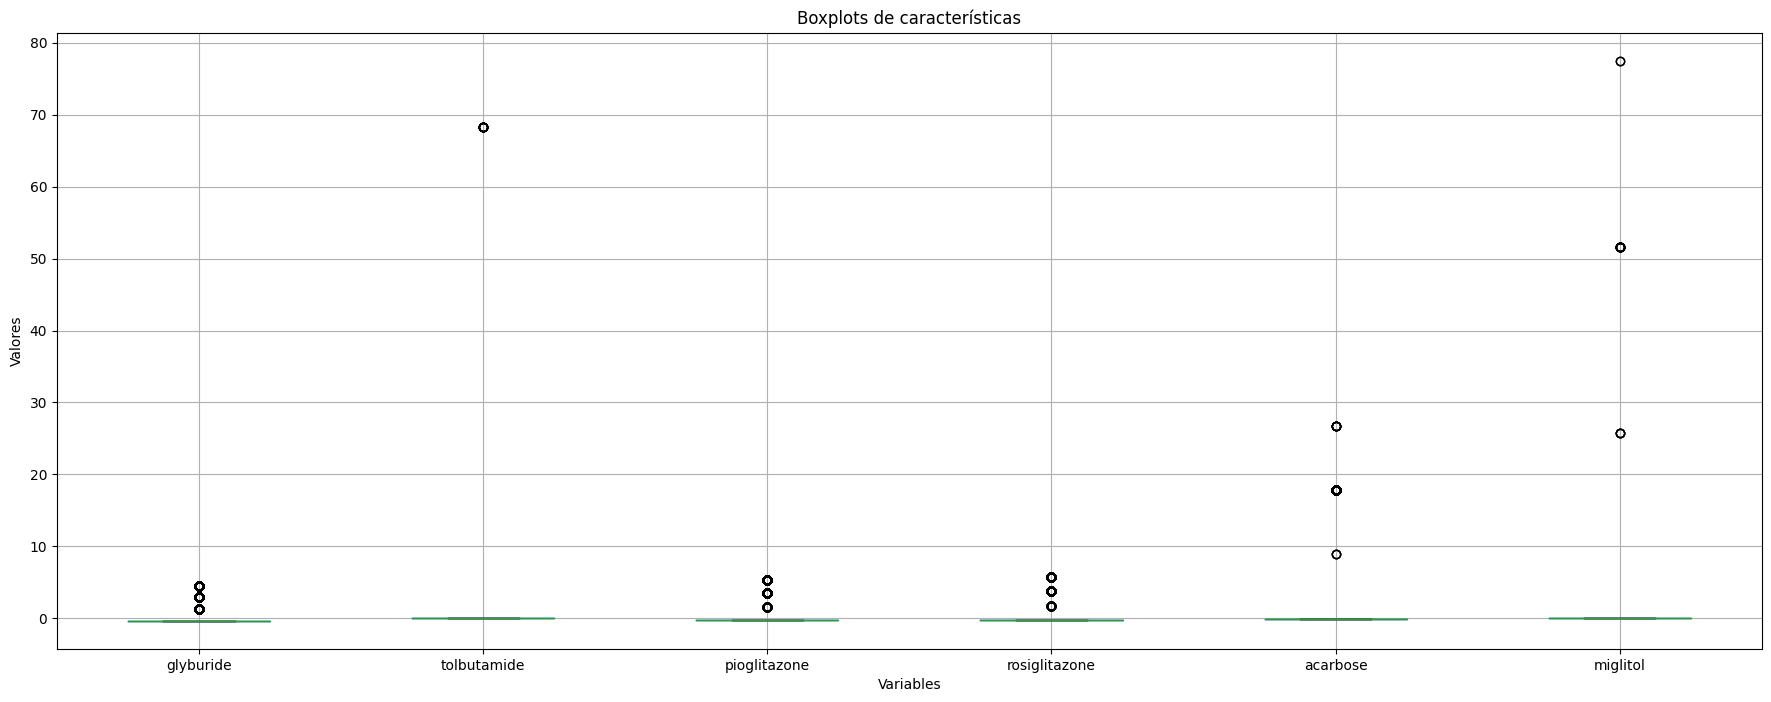

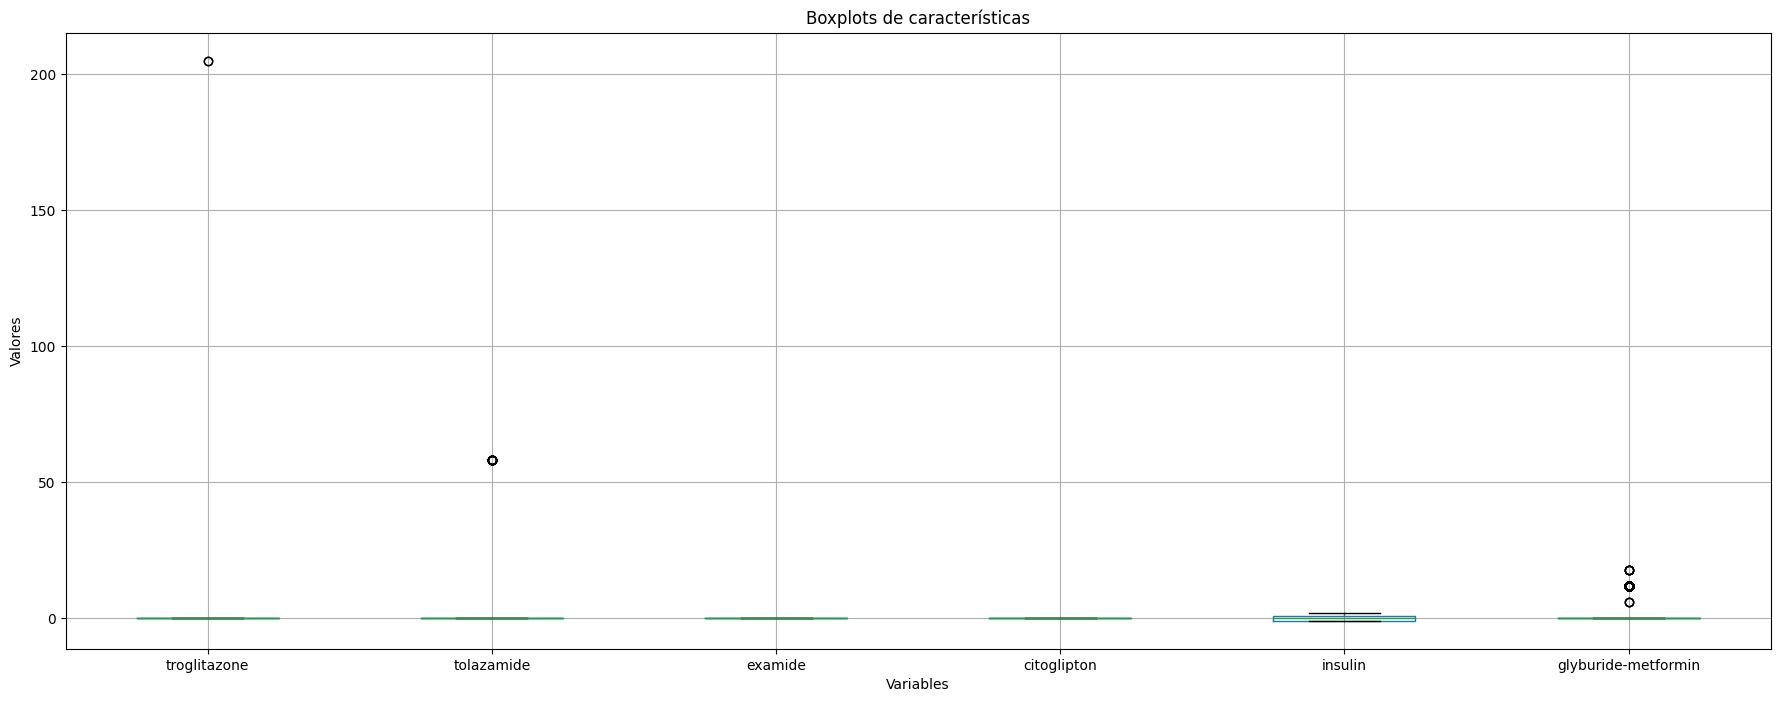

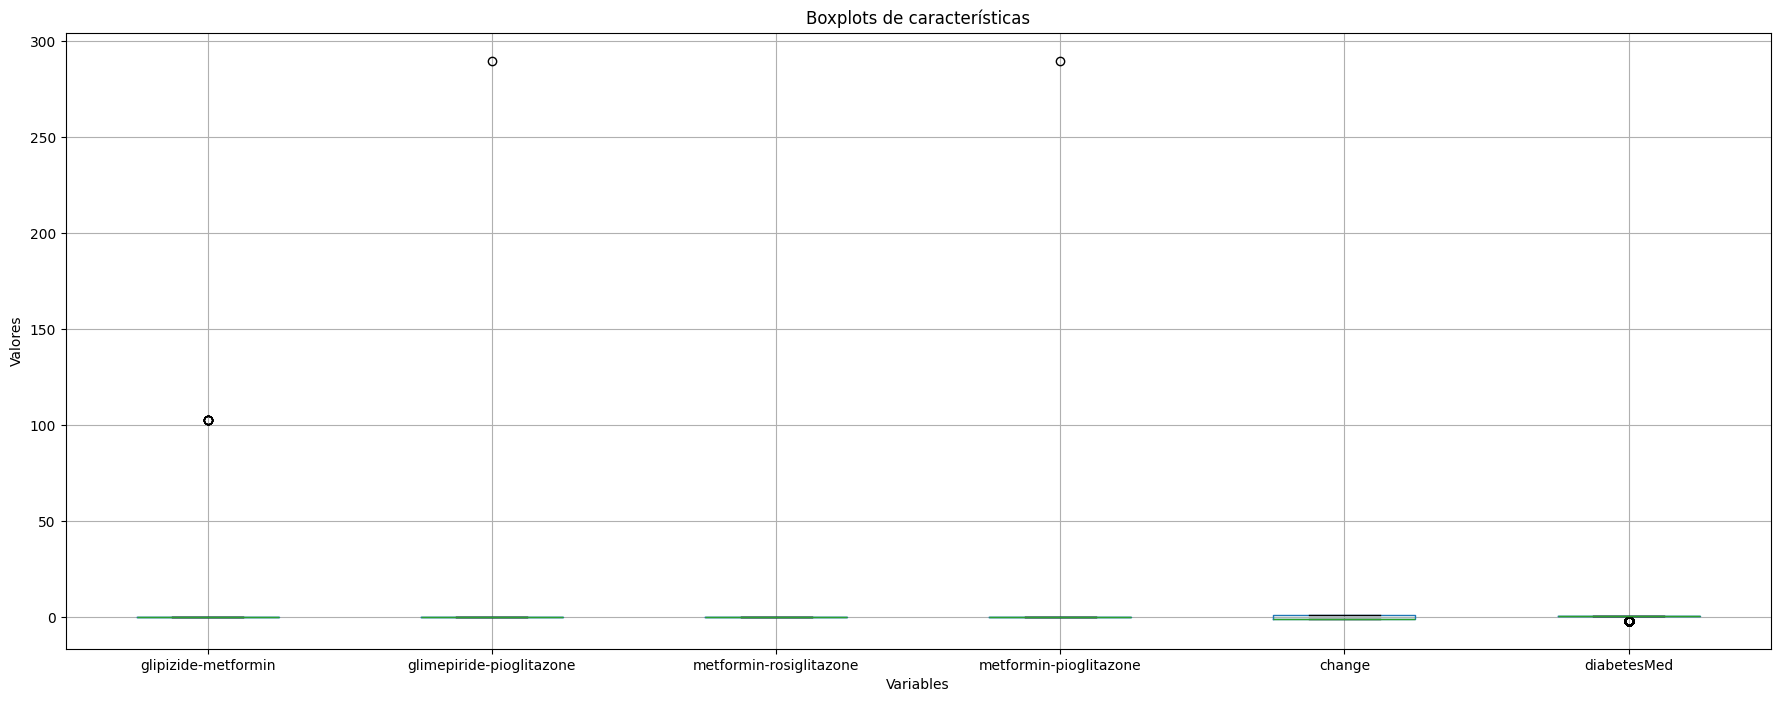

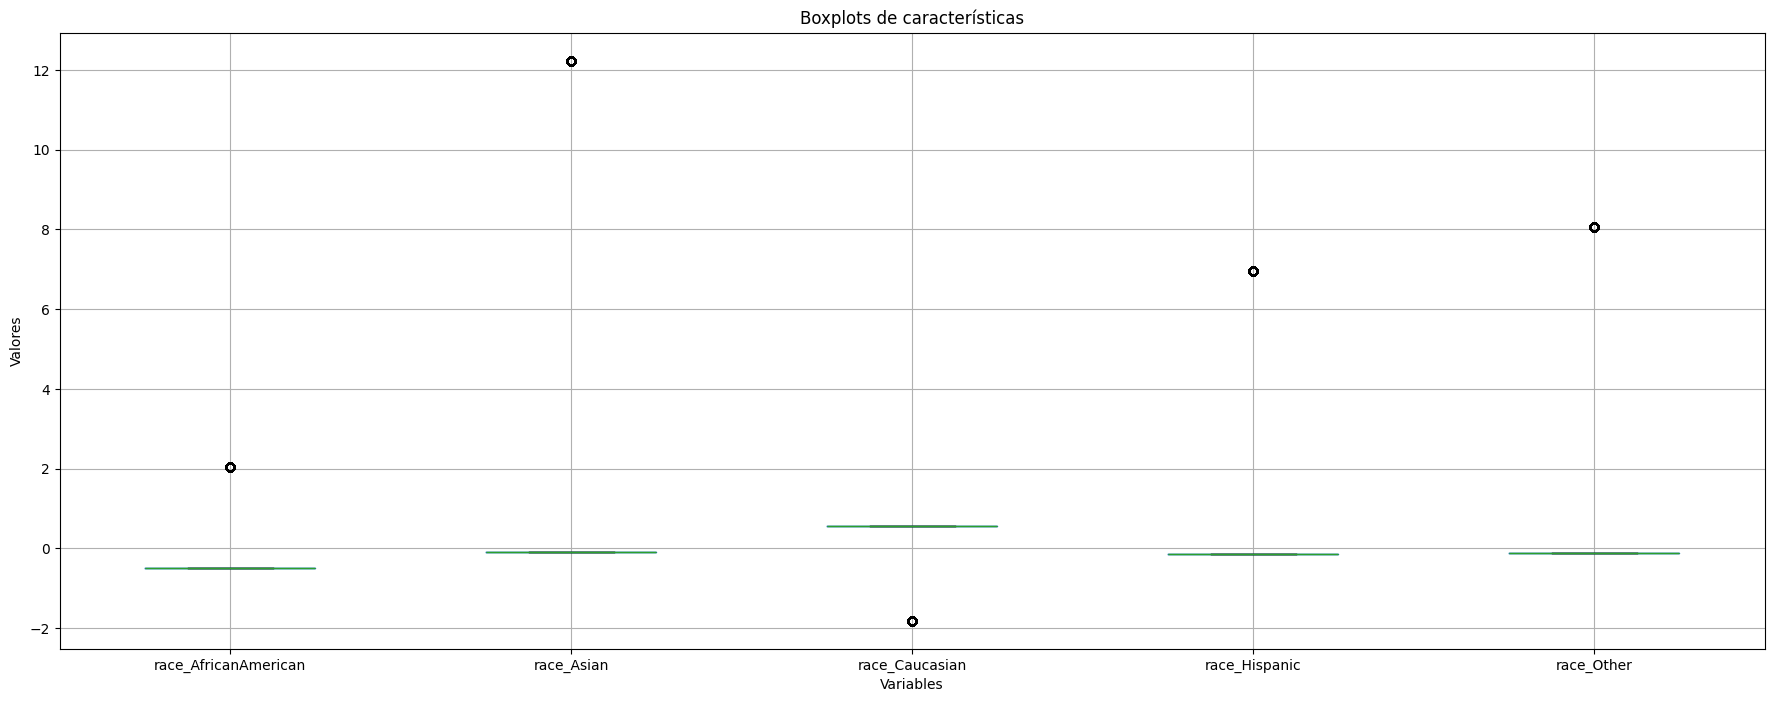

In [137]:
for i in range(0, X_ord.shape[1], 6):
    plt.figure(figsize=(22, 8))
    X_ord.iloc[:, i:i + 6].boxplot()
    plt.title(f'Boxplots de características')
    plt.xlabel('Variables')
    plt.ylabel('Valores')
    plt.grid(True)
    plt.show()

Es complicado sacar conclusiones al ser tantas varacterísticas, pero hay algunas evidentes:

-   En las variables binarias, los valores fuera de la caja son los 0 o 1 menos comunes en cada característica. Cuando la caja va de 0 a 1 es que el número de 0 y 1 es muy similar (gender o change)
- En otras características vemos como hay valores atípicos pero que vamos a considerar como reales, no como errores. Por ejemplo, en medical specialty, la mayoría son de valores son el mismo (con los que hicimos la imputación), por eso la caja está abajo y hay más valores arriba, pero que no podemos descartar al ser reales.
- También debemos considerar el problema, en el cual tenemos más de 80000 instancias.

Por ejemplo, podemos ver el histograma de estas variables donde hay muchos valores fuera de la caja:

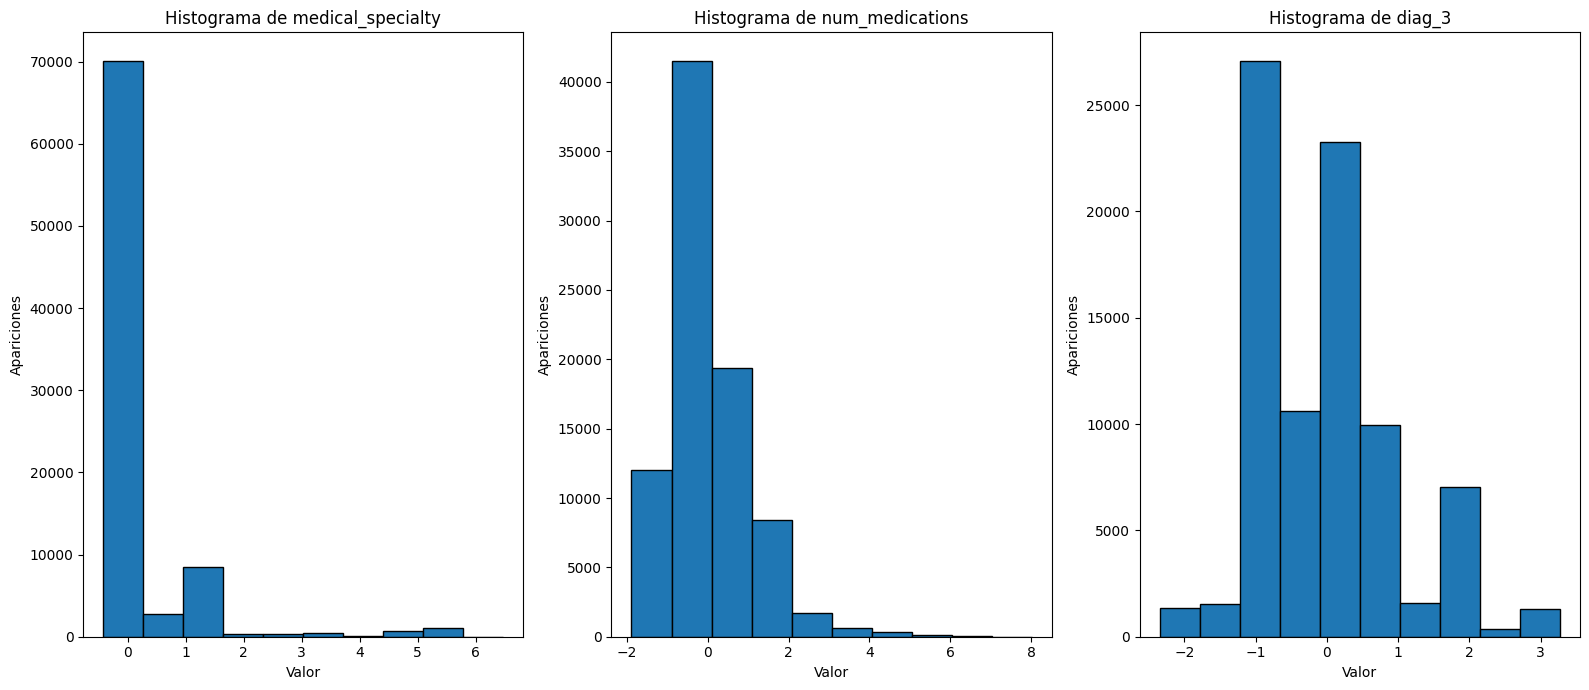

In [138]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 3, 1)  
plt.hist(X_ord['medical_specialty'], edgecolor='black')
plt.title('Histograma de medical_specialty')
plt.xlabel('Valor')
plt.ylabel('Apariciones')

plt.subplot(1, 3, 2)  
plt.hist(X_ord['num_medications'], edgecolor='black')
plt.title('Histograma de num_medications')
plt.xlabel('Valor')
plt.ylabel('Apariciones')

plt.subplot(1, 3, 3)  
plt.hist(X_ord['diag_3'], edgecolor='black')
plt.title('Histograma de diag_3')
plt.xlabel('Valor')
plt.ylabel('Apariciones')

plt.tight_layout()
plt.show()


Aquí vemos por qué hay tantos fuera en los boxplot. Estas variables suelen tomar valores muy concentrados alrededor de un único valor específico

Para X_oh no se hace este estudio pues tenemos más de 100 columnas, además sería todo igual menos en las columnas del one hot.

### Matriz de correlación

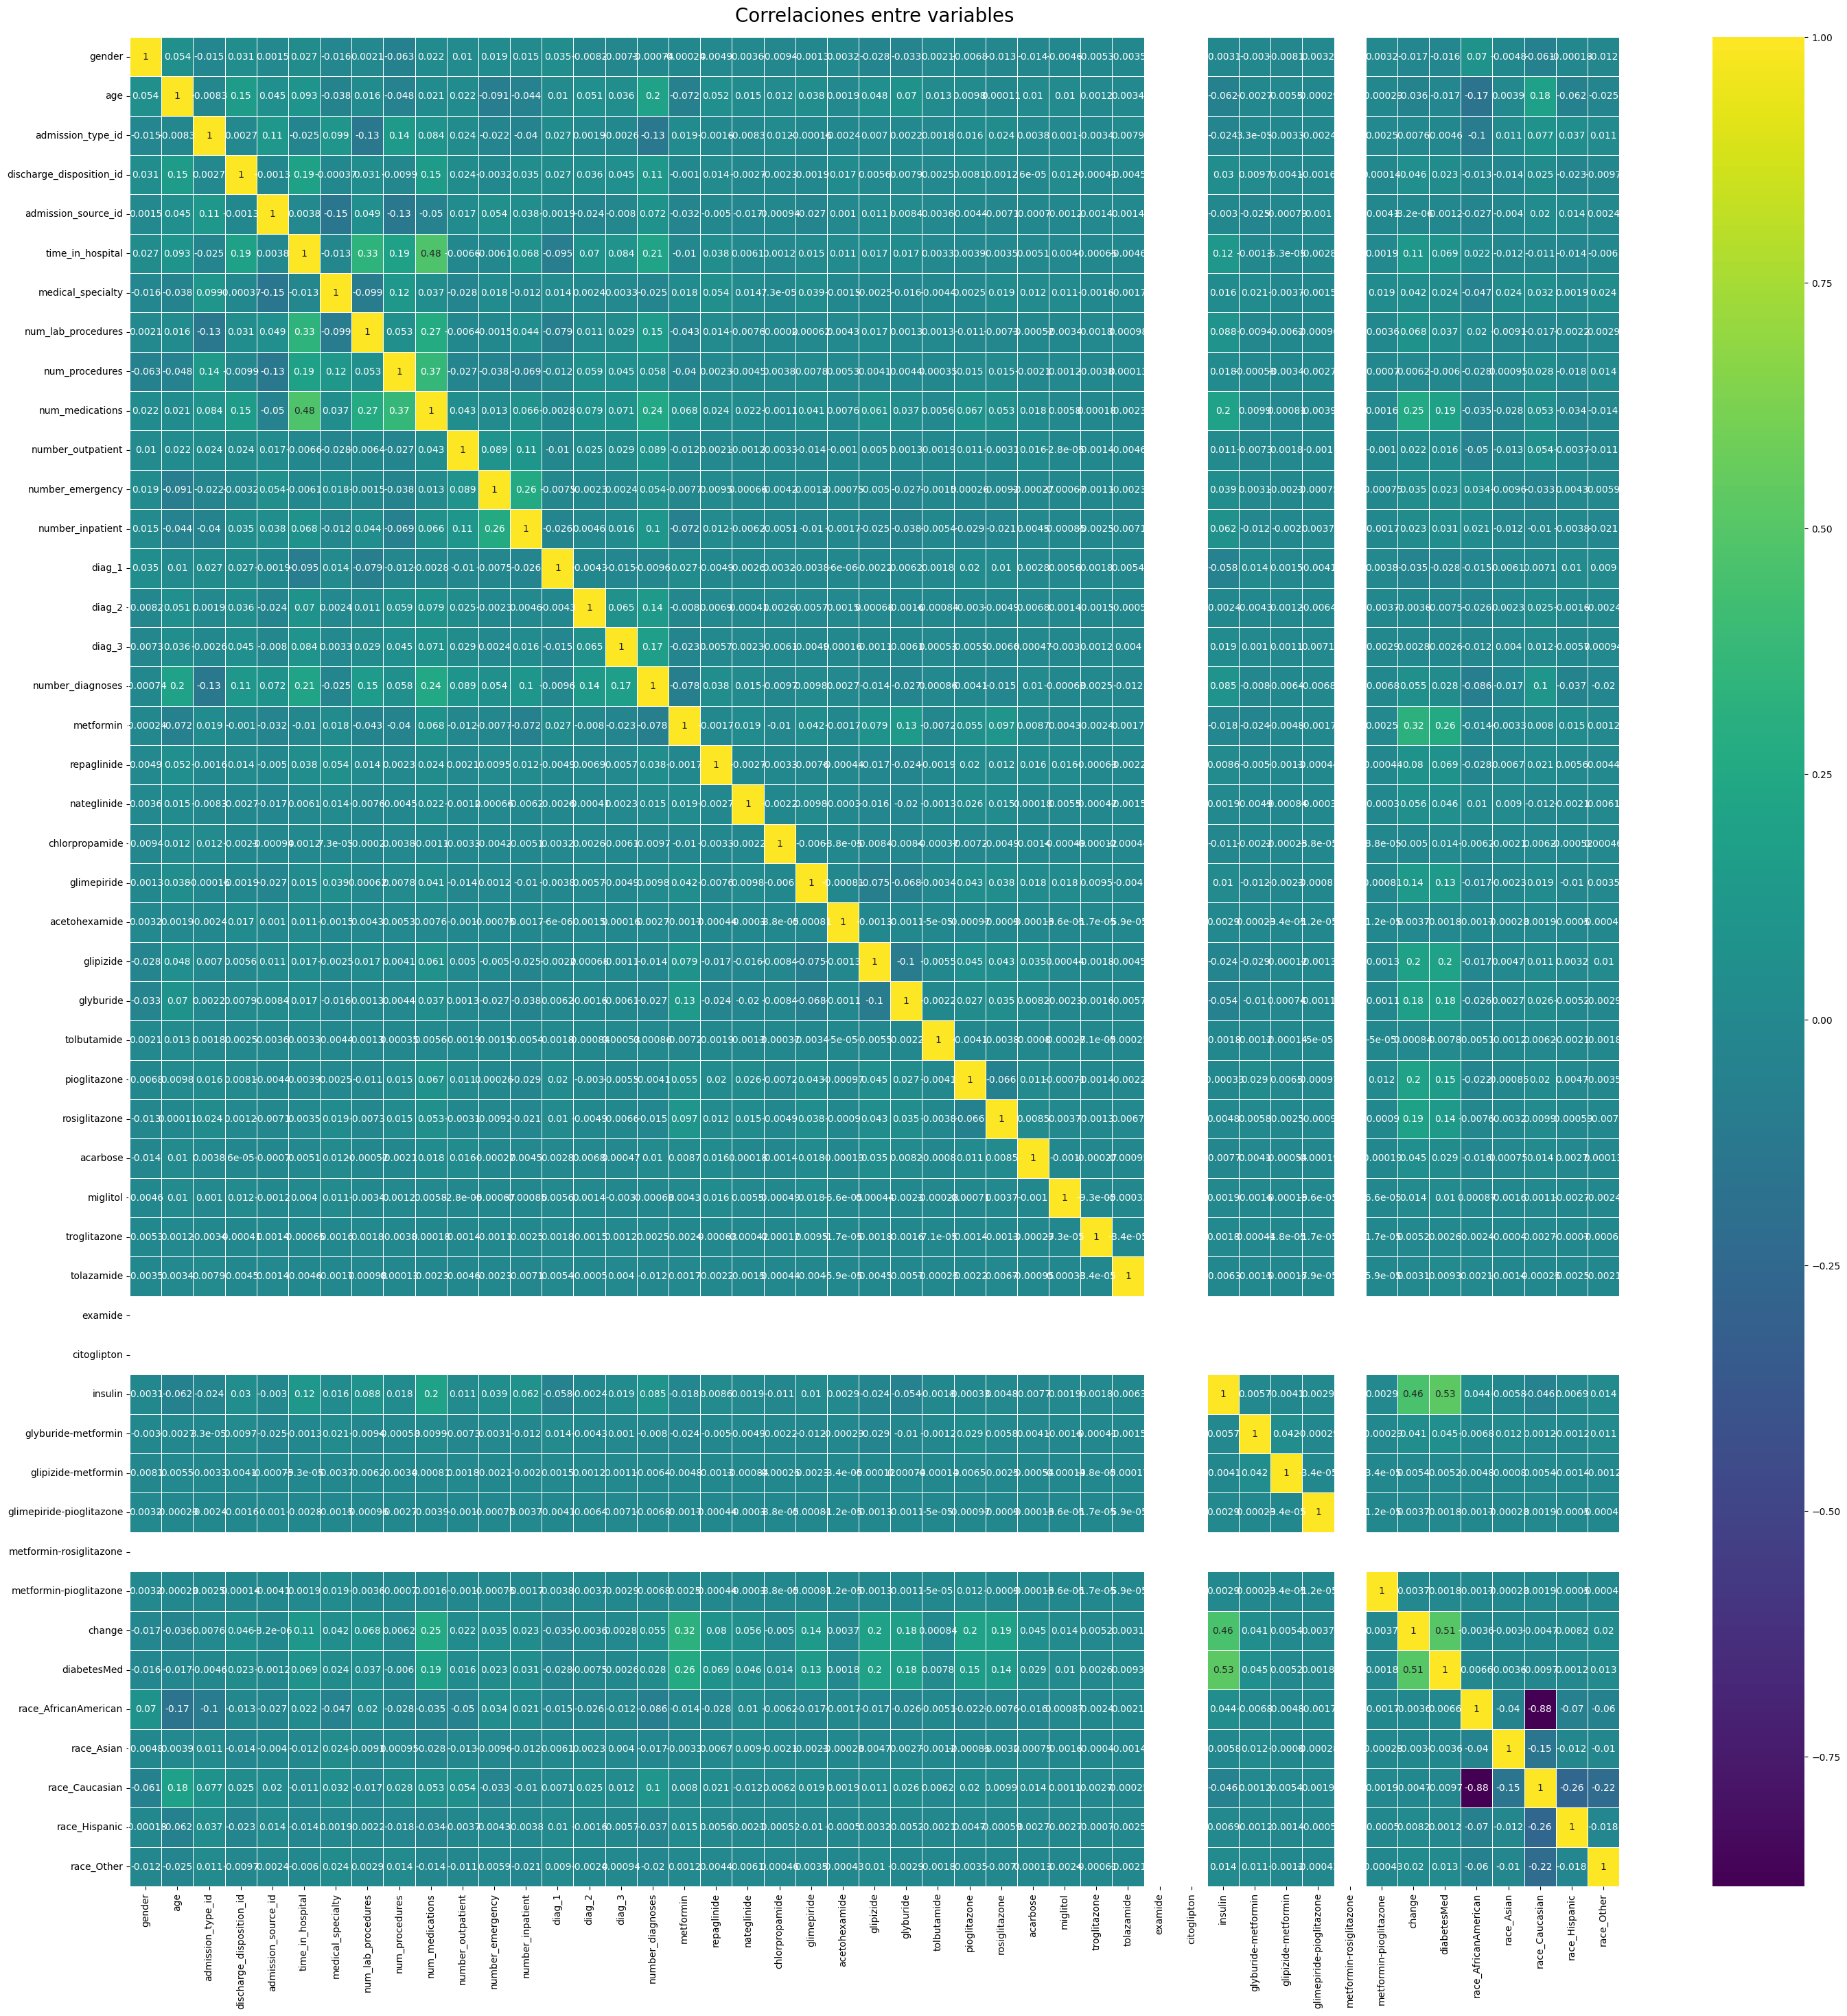

In [139]:

plt.figure(figsize=(35, 35))
heatmap=sns.heatmap(X_ord.corr(), annot=True, cmap='viridis', linewidths=.5)
heatmap.set_title('Correlaciones entre variables', fontdict={'fontsize':20}, pad=16);
plt.show()

Aunque con tantas columnas la visualzación es complicada, observamos que hay 3 variables cuyos elementos son todos el mismo:

In [140]:
X_ord['examide'].value_counts(),X_ord['citoglipton'].value_counts(),X_ord['metformin-rosiglitazone'].value_counts()

(examide
 0.0    84087
 Name: count, dtype: int64,
 citoglipton
 0.0    84087
 Name: count, dtype: int64,
 metformin-rosiglitazone
 0.0    84087
 Name: count, dtype: int64)

Estas no aportarán nada a nuestras predicciones, asi que las eliminamos:

In [141]:
X_ord.drop(columns=['examide','citoglipton','metformin-rosiglitazone'],inplace=True)
X_oh.drop(columns=['examide','citoglipton','metformin-rosiglitazone'],inplace=True)

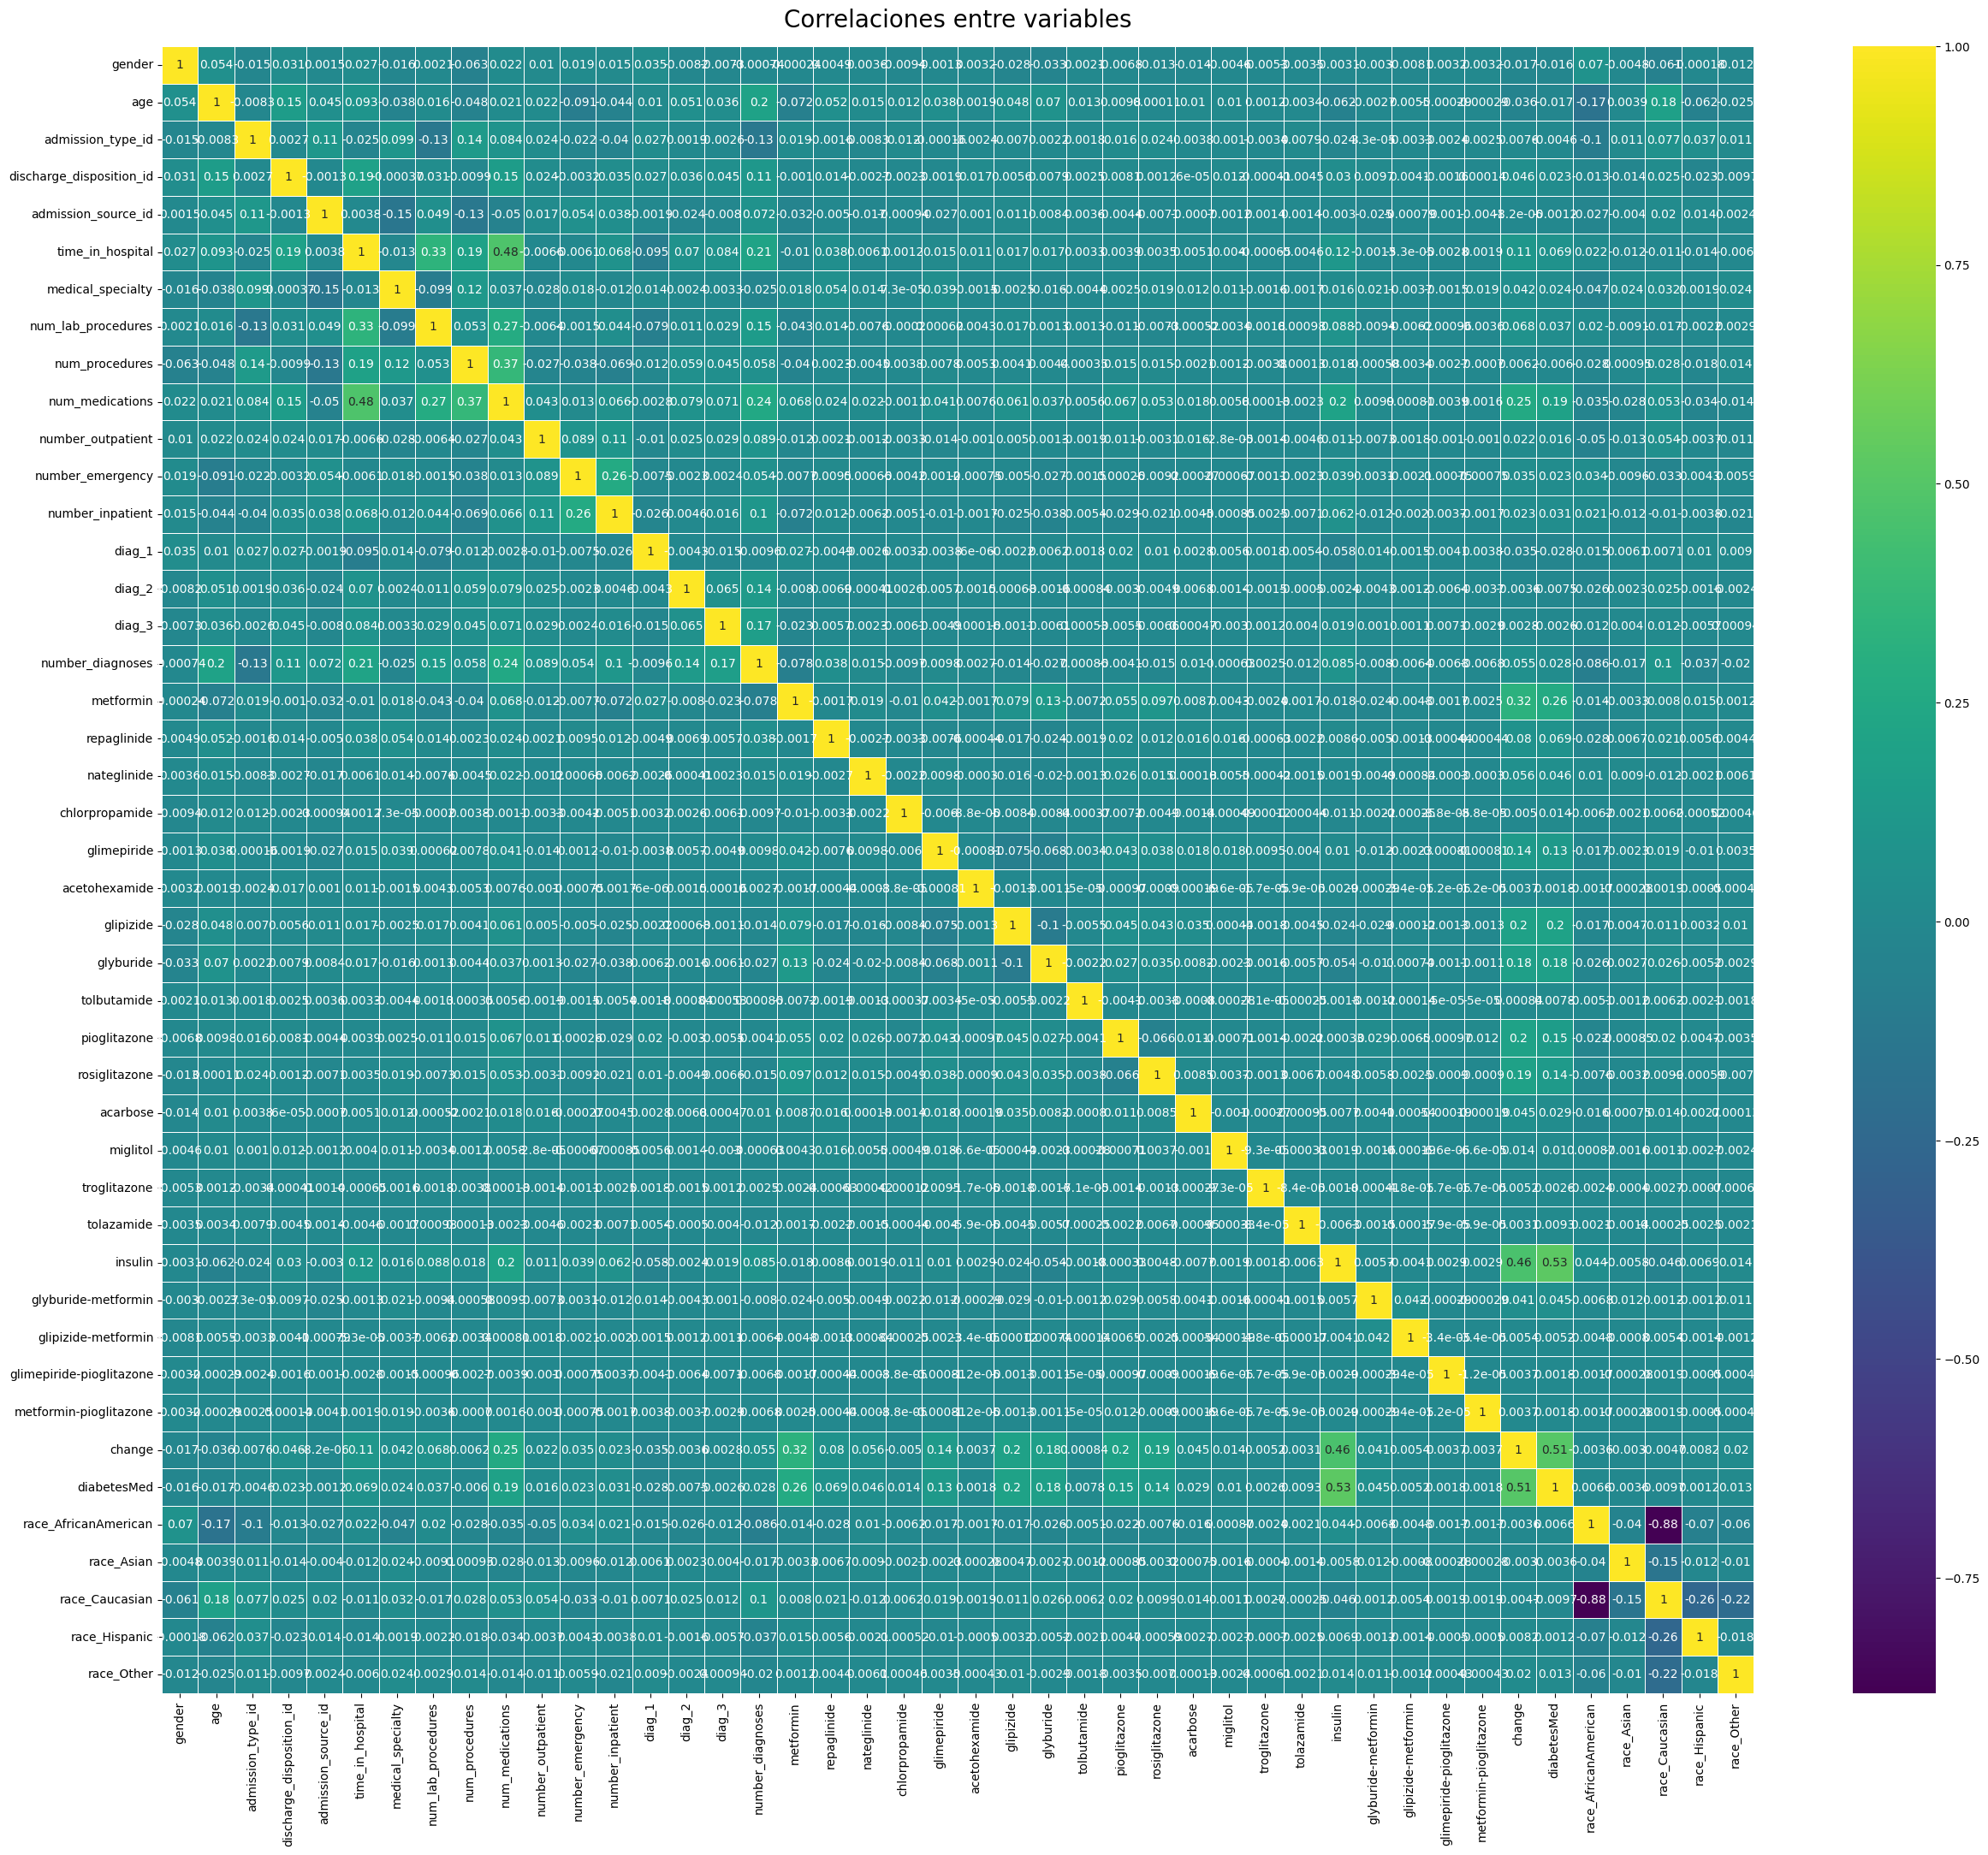

In [142]:
plt.figure(figsize=(30, 25))
heatmap = sns.heatmap(X_ord.corr(), annot=True, cmap='viridis', linewidths=.5)
heatmap.set_title('Correlaciones entre variables', fontdict={'fontsize':20}, pad=16);
plt.show()

Ahora podemos ver que no hay mucha correlación entre variables, si acaso destaca un poco la correlación (inversa en este caso) entre las variables 'race_AfricanAmerican' y 'race_Asian', lo cual vamos a dejar pasar puesto que esta correlacion es obvia, alguien que es afroamericano no es asiático. 

También, vemos que hay algo de correlación (sobre 0.5) entre las variables insulin (si se receto insulina o no, o si la dosis aumento o disminuyo), diabetesMed (Si alguien se diagnostica con diabetes) y change (si hubo cambio en la medicaciópn o no). Evidentemente, la correlación entre insulin y diabetesMed sugiereque los pacientes que tienen diabetes se les suele recetar insulina. La relación entre insulina y change se debe a que un ajuste en la dosis de insulina, provoca un change de 1. 

Con estas consideraciones, no estamos en disposición de ver una fuerte correlación entre variables y así poder eliminar alguna. Podemos ver el scatter plot de estas variables:

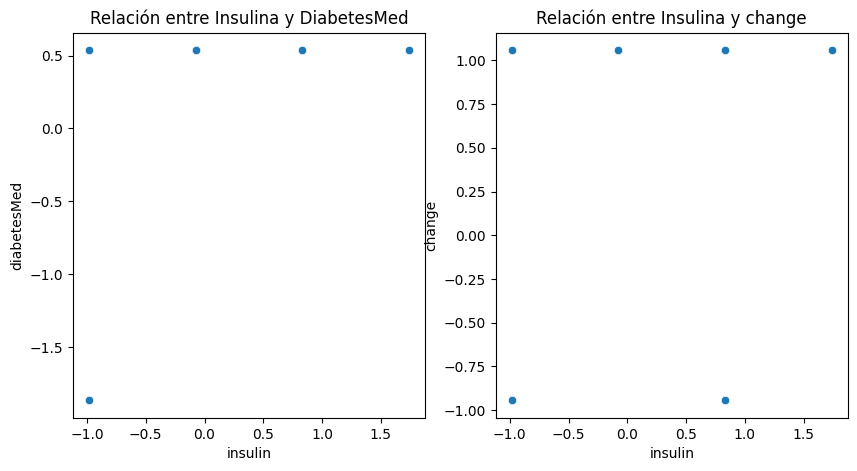

In [143]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.scatterplot(x=X_ord['insulin'], y=X_ord['diabetesMed'])
plt.title('Relación entre Insulina y DiabetesMed')

plt.subplot(1,2,2)
sns.scatterplot(x=X_ord['insulin'], y=X_ord['change'])
plt.title('Relación entre Insulina y change')
plt.show()

Observamos que cuando no se diagnostica diabetes, no se receta insulina. Sin embargo, hay casos en los que se detecta diabetes, pero no se receta insulina. Además, cuando no se receta insulina (insulina=0) o la dosis es constante (insulina=0.8), hay casos en los que no hay cambio (cambio=-1), es decir, tampoco hay cambios en las demas medicinas. Los casos en los que la insulina es constante y sí hay cambio (cambio=1) se deben a otras medicinas.

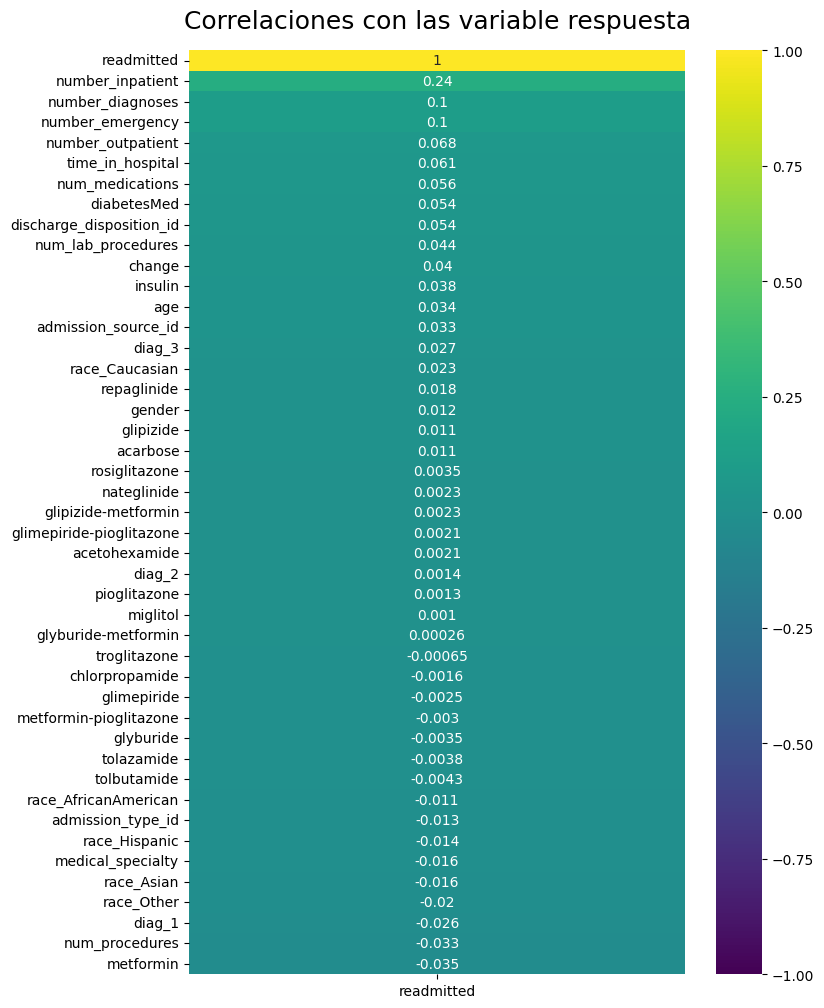

In [144]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(pd.concat([X_ord, y], axis=1).corr()[['readmitted']].sort_values(by='readmitted', ascending=False), vmin=-1, vmax=1, annot=True, cmap='viridis')
heatmap.set_title('Correlaciones con las variable respuesta', fontdict={'fontsize':18}, pad=16);

Vemos como los pacientes que mas ingresos previos han tenido son los que mas probabilidad tienen de ser reingresados. Igual pasa con el número de veces que se ha acudido a urgencias. Al contrario, el uso de metformina está negativamente correlacionado con el ingreso, igual que el diagnóstico primero que s ehace al paciente. Por otro lado, la mayoría de los medicamentos específicos (como glimepiride, tolazamide, glyburide) tienen correlaciones muy bajas o cercanas a cero, lo que indica que no hay una relación fuerte entre estos medicamentos y la probabilidad de reingreso.Igual pasa con el género del paciente, lo que sugiere que no hay una diferencia significativa en la tasa de reingreso entre hombres y mujeres.



Con estas consideraciones,  estamos en disposición de eliminar algunas variables, por ejemplo las variables que no están relacionadas con la respuesta, como glimepiride,troglitazone,glyburide-metformin. Además, sobre las razas vemos que la caucásica está más relacionada simplemente porque la mayoría de registros son de pacientes caucásicos. 

In [145]:
X_ord.drop(columns=['glimepiride','troglitazone','glyburide-metformin'],inplace=True)
X_oh.drop(columns=['glimepiride','troglitazone','glyburide-metformin'],inplace=True)

### Método de envoltura para seleccionar características

Podemos seguir con la selección de características usando métodos de envoltura:

In [147]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe=RFE(estimator=model,n_features_to_select=5)

rfe.fit(X_ord, y)

print(rfe.ranking_)


[15  3 21  1 11  5 22 13  6 23  1  1  1  7 17 18  1  4 32 37 24 25 33 30
 31 12 14 16 27 36  8 34 28 29  9  2 35 19 10 26 20]


In [148]:
model_oh = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe_oh=RFE(estimator=model_oh,n_features_to_select=5)

rfe_oh.fit(X_oh, y)

print(rfe_oh.ranking_)


[ 35  10  36   1  60  27  37  13  12   3   1   1  14  41  42   1   8  92
 107  62  52  94  83  90  32  38  40  78 106  20 102  59  68  31   4  93
  39  28  77  56  70 103  18  15  82  26  34  30  44  91  46  50   2  88
  72  97  76  45  24  43  65  99  85   7  73  79  74  21  98   1 104  54
  96  22  80  64   5  23  53   9  61  66   6  16  55  69  75  63  19  81
  48  47  71  33  95  67  58  86  84  11 105  49  17  29  25  89  57 101
  51 100  87]


Con este estudio, que coincide en gran parte con el mostrado en la correlación con la variable de características, podemos eliminar la última característica (de momento), que no aportará nada al problema.

In [149]:
columnas_a_eliminar = X_ord.columns[[20, 26, 10]]

X_ord.drop(columns=columnas_a_eliminar, inplace=True)

In [150]:
columnas_a_eliminar = X_oh.columns[[51,100,87,101,57,89]]

X_oh.drop(columns=columnas_a_eliminar, inplace=True)

Recapitulando, y antes de entrenar a los distintos modelos, recapitulamos:

- X_ord: df donde los valores categóricos de medical_specialty se han cambiado por números, introduciendo ordinalidad artificial
- X_oh: df donde los valores categóricos de medical_specialty se han cambiado por vectores one-hot, aumentando la dimensionalidad


In [151]:
X_ord.shape,X_oh.shape

((84087, 38), (84087, 105))

## Entrenamiento de modelos

Con estos datos, antes de entrenar los modelos, vemos que las clases no están balanceadas, con lo que la clase minoritaria será poco predecida por el modelo, así que primero tratamos este problema utilizando:

- Clases con peso en el modelo base
- Oversampling
- Undersampling

Luego, con la mejor técnica que encontremos de balanceo, entrenaremos un XGBoost que será nuestro modelo final.

### Balance de clases

In [152]:
y.value_counts()

readmitted
0    43943
1    30540
2     9604
Name: count, dtype: int64

#### LR Multinomial

In [153]:
def rendimiento(clasificador, X, y):
    
    y_pred = clasificador.predict(X)
    
    accuracy=accuracy_score(y,y_pred)

    print("Precisión del modelo: {}".format(accuracy))
    print()
    print("Reporte de Clasificación:")
    print(classification_report(y, y_pred))
    
    return accuracy

In [184]:
X_ord_train,X_ord_test,y_train,y_test=train_test_split(X_ord,y,test_size=0.2,random_state=4)
X_oh_train,X_oh_test,y_train,y_test=train_test_split(X_oh,y,test_size=0.2,random_state=4)

##### Sin balanceo

In [210]:
lr_model_unbalanced1 = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_model_unbalanced1.fit(X_ord_train, y_train)

rendimiento(lr_model_unbalanced1,X_ord_test,y_test)

Precisión del modelo: 0.5604114639077179

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.58      0.88      0.70      8851
           1       0.49      0.26      0.34      6061
           2       0.36      0.02      0.03      1906

    accuracy                           0.56     16818
   macro avg       0.48      0.39      0.36     16818
weighted avg       0.52      0.56      0.49     16818



0.5604114639077179

In [211]:
lr_model_unbalanced2 = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_model_unbalanced2.fit(X_oh_train, y_train)

rendimiento(lr_model_unbalanced2,X_oh_test,y_test)

Precisión del modelo: 0.5620763467713165

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.58      0.88      0.70      8851
           1       0.50      0.27      0.35      6061
           2       0.34      0.02      0.03      1906

    accuracy                           0.56     16818
   macro avg       0.47      0.39      0.36     16818
weighted avg       0.52      0.56      0.50     16818



0.5620763467713165

Observando el recall, la métrica más importante en este caso pues nos interesa minimizar los falsos negativos al ser un caso médico, vemos que el modelo no es capaz de predecir la clase 2, casi todas las instancias las clasifica como 0. Hay que introducir balance de clases para mejorar el modelo.

##### Balanced class weight en modelo

In [185]:
lr_model1 = LogisticRegression(solver='lbfgs', max_iter=10000,class_weight='balanced')
lr_model1.fit(X_ord_train, y_train)

rendimiento(lr_model1,X_ord_test,y_test)

Precisión del modelo: 0.4791295041027471

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      8851
           1       0.44      0.26      0.33      6061
           2       0.18      0.39      0.25      1906

    accuracy                           0.48     16818
   macro avg       0.41      0.43      0.40     16818
weighted avg       0.51      0.48      0.48     16818



0.4791295041027471

In [186]:
lr_model2 = LogisticRegression(solver='lbfgs', max_iter=10000,class_weight='balanced')
lr_model2.fit(X_oh_train, y_train)

rendimiento(lr_model2,X_oh_test,y_test)

Precisión del modelo: 0.4840052324889999

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.63      0.64      0.63      8851
           1       0.45      0.29      0.35      6061
           2       0.19      0.40      0.26      1906

    accuracy                           0.48     16818
   macro avg       0.42      0.44      0.41     16818
weighted avg       0.52      0.48      0.49     16818



0.4840052324889999

##### Undersampling

In [193]:
undersampler = NearMiss() 

X_oh_under, y_under = undersampler.fit_resample(X_oh, y)
X_ord_under, y_under = undersampler.fit_resample(X_ord, y)

X_oh_under_train, X_oh_under_test, y_under_train, y_under_test = train_test_split(X_oh_under, y_under , test_size = 0.2, random_state = 42)
X_ord_under_train, X_ord_under_test, y_under_train, y_under_test = train_test_split(X_ord_under, y_under , test_size = 0.2, random_state = 42)

In [195]:
lr_model_under1= LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model_under1.fit(X_ord_under_train, y_under_train)

rendimiento(lr_model_under1,X_ord_under_test,y_under_test)

Precisión del modelo: 0.5651570362658338

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.66      0.58      1896
           1       0.47      0.37      0.41      1939
           2       0.70      0.67      0.69      1928

    accuracy                           0.57      5763
   macro avg       0.56      0.57      0.56      5763
weighted avg       0.56      0.57      0.56      5763



0.5651570362658338

In [196]:
lr_model_under2= LogisticRegression(solver='lbfgs', max_iter=1000)
lr_model_under2.fit(X_oh_under_train, y_under_train)

rendimiento(lr_model_under2,X_oh_under_test,y_under_test)

Precisión del modelo: 0.5724449071664064

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.53      0.65      0.59      1896
           1       0.47      0.39      0.42      1939
           2       0.72      0.68      0.70      1928

    accuracy                           0.57      5763
   macro avg       0.57      0.57      0.57      5763
weighted avg       0.57      0.57      0.57      5763



0.5724449071664064

##### Oversampling

In [197]:
oversampler = SMOTE() 

X_oh_over, y_over = oversampler.fit_resample(X_oh, y)
X_ord_over, y_over = oversampler.fit_resample(X_ord, y)

X_oh_over_train, X_oh_over_test, y_over_train, y_over_test = train_test_split(X_oh_over, y_over , test_size = 0.2, random_state = 42)
X_ord_over_train, X_ord_over_test, y_over_train, y_over_test = train_test_split(X_ord_over, y_over , test_size = 0.2, random_state = 42)

In [198]:
lr_model_over1 = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_model_over1.fit(X_ord_over_train, y_over_train)

rendimiento(lr_model_over1,X_ord_over_test,y_over_test)

Precisión del modelo: 0.4324888113479481

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.44      0.63      0.52      8826
           1       0.38      0.28      0.32      8734
           2       0.46      0.39      0.42      8806

    accuracy                           0.43     26366
   macro avg       0.43      0.43      0.42     26366
weighted avg       0.43      0.43      0.42     26366



0.4324888113479481

In [200]:
lr_model_over2 = LogisticRegression(solver='lbfgs', max_iter=10000)
lr_model_over2.fit(X_oh_over_train, y_over_train)

rendimiento(lr_model_over2,X_oh_over_test,y_over_test)

Precisión del modelo: 0.44462565425168776

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.45      0.62      0.52      8826
           1       0.40      0.29      0.34      8734
           2       0.46      0.42      0.44      8806

    accuracy                           0.44     26366
   macro avg       0.44      0.44      0.43     26366
weighted avg       0.44      0.44      0.43     26366



0.44462565425168776

Como vemos, el mejor resultado se obtiene haciendo undersampling, asique seguiremos con esos datos ahora en adelante para buscar el mejor modelo. Utilizaremos XGBoost con GridSearch para los hiperaprámetros.

#### Modelo XGBoost 

Debido a la complejidad de los datos, utilizaremos un XGBoost pata la clasificación multiclase. Además, suele superar a otros modelos en la mayoría de problemas. También usaremos GridSearchCV para la búsqueda de los mejores hiperparámetros.

##### GridSearchCV

In [201]:
xgb_ord = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

param_grid = {
    'max_depth': [6, 7, 8],  
    'learning_rate': [0.03, 0.05, 0.1],  
    'n_estimators': [500, 600],
    'colsample_bytree': [0.2, 0.3], 
    'gamma': [0.9,1.1], 
}

grid_search_xgb_ord = GridSearchCV(estimator=xgb_ord, param_grid=param_grid, cv=3, n_jobs=-1)

grid_search_xgb_ord.fit(X_ord_under_train, y_under_train)

print("Mejores parámetros encontrados:", grid_search_xgb_ord.best_params_)

Mejores parámetros encontrados: {'colsample_bytree': 0.2, 'gamma': 1.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500}


In [202]:
best_xgb_ord = grid_search_xgb_ord.best_estimator_

rendimiento(best_xgb_ord,X_ord_under_test,y_under_test)

Precisión del modelo: 0.6021169529758806

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.55      0.65      0.59      1896
           1       0.50      0.46      0.48      1939
           2       0.78      0.70      0.74      1928

    accuracy                           0.60      5763
   macro avg       0.61      0.60      0.60      5763
weighted avg       0.61      0.60      0.60      5763



0.6021169529758806

In [164]:
xgb_oh = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.03, 0.05, 0.1],  
    'n_estimators': [300, 400, 500],
    'colsample_bytree': [0.1, 0.2], 
    'gamma': [0.5, 0.7], 
}

grid_search_xgb_oh = GridSearchCV(estimator=xgb_oh, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

grid_search_xgb_oh.fit(X_oh_under_train, y_under_train)

print("Mejores parámetros encontrados:", grid_search_xgb_oh.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros encontrados: {'colsample_bytree': 0.1, 'gamma': 0.5, 'max_depth': 7, 'n_estimators': 400}


In [203]:
best_xgb_oh = grid_search_xgb_oh.best_estimator_

rendimiento(best_xgb_oh,X_oh_under_test,y_under_test)

Precisión del modelo: 0.6102724275550928

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60      1896
           1       0.50      0.48      0.49      1939
           2       0.80      0.71      0.75      1928

    accuracy                           0.61      5763
   macro avg       0.62      0.61      0.61      5763
weighted avg       0.62      0.61      0.61      5763



0.6102724275550928

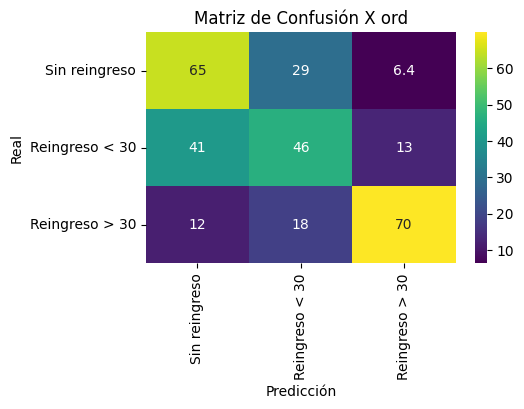

In [204]:
cm = confusion_matrix(y_under_test, best_xgb_ord.predict(X_ord_under_test))
plt.figure(figsize=(5, 3))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True) * 100, cmap='viridis', annot=True,xticklabels=["Sin reingreso","Reingreso < 30","Reingreso > 30"], yticklabels=["Sin reingreso","Reingreso < 30","Reingreso > 30"])

plt.title('Matriz de Confusión X ord')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()

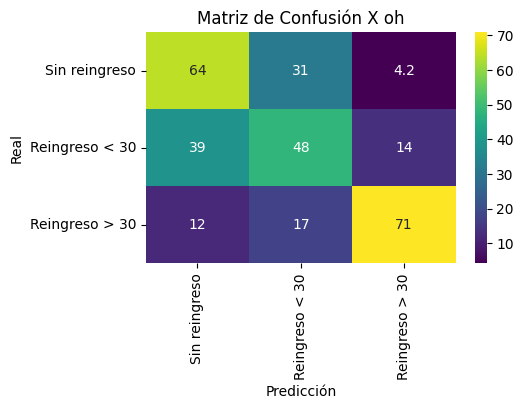

In [205]:
cm = confusion_matrix(y_under_test, best_xgb_oh.predict(X_oh_under_test))
plt.figure(figsize=(5, 3))
sns.heatmap(cm / cm.sum(axis=1, keepdims=True) * 100, cmap='viridis', annot=True,xticklabels=["Sin reingreso","Reingreso < 30","Reingreso > 30"], yticklabels=["Sin reingreso","Reingreso < 30","Reingreso > 30"])

plt.title('Matriz de Confusión X oh')
plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()

Estas matrices de confusión muestran porcentajes, no el total de instancias clasificadas en cada clase. Es decir, en cada fila real se suma el 100%.

Mirando las matrices de confusión, vemos que las clases 0 y 2 se predicen bien, pero la 1 no tanto, en yuxtaposición a lo que teníamos en el modelo sin balanceo de clases, que no se predecía la 2. El modelo clasifica como 0 muchas instancias que en realidad son clase 1, y viceversa. No distingue del todo bien las clases 0 y 1, mientras que la 2 sí. Lo que se ve en la diagonal es el recall de cada clase, que en este problema de carácter médico, es la métrica más importante pues interesa minimizar los falsos negativos. Queremos que el modelo capture la mayoría de casos positivos.

##### Importancia de Características

Para temrinar e intentar mejorar los modelos, veremos qué características son más iomportantes a la hora de la clasificiación. Así, podremos ver las no relevantes y eliminarlas.

                     feature  importance
30    metformin-pioglitazone    0.000000
29  glimepiride-pioglitazone    0.000000
28       glipizide-metformin    0.000000
26                tolazamide    0.000000
25                  miglitol    0.000000
22               tolbutamide    0.000000
19             acetohexamide    0.000000
0                     gender    0.009790
24                  acarbose    0.011133
7         num_lab_procedures    0.013960


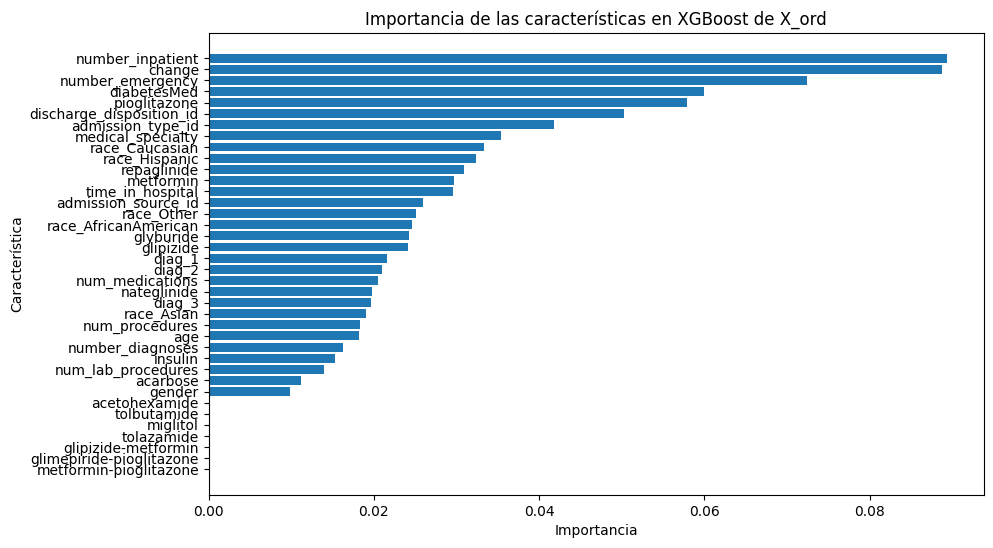

In [206]:
feature_importances_ord = best_xgb_ord.feature_importances_


feature_importance_df_ord = pd.DataFrame({
    'feature': X_ord_under_train.columns,
    'importance': feature_importances_ord
}).sort_values(by='importance', ascending=True)

print(feature_importance_df_ord.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_ord['feature'], feature_importance_df_ord['importance'])
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.title("Importancia de las características en XGBoost de X_ord")
plt.show()


Vemos si mejora el modelo eliminando las 10 características menos importantes:

In [207]:
low_importance_features = feature_importance_df_ord.nsmallest(10, 'importance')['feature']

X_ord_train_reduced = X_ord_under_train.drop(columns=low_importance_features)
X_ord_test_reduced = X_ord_under_test.drop(columns=low_importance_features)

new_model_ord = XGBClassifier(**grid_search_xgb_ord.best_params_)
new_model_ord.fit(X_ord_train_reduced, y_under_train)

rendimiento(new_model_ord,X_ord_test_reduced,y_under_test)

Precisión del modelo: 0.6073225750477182

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      1896
           1       0.51      0.46      0.48      1939
           2       0.78      0.71      0.74      1928

    accuracy                           0.61      5763
   macro avg       0.61      0.61      0.61      5763
weighted avg       0.61      0.61      0.61      5763



0.6073225750477182

Mejoramos aproximadamente un 0.5%, un aumento prácticamente residual, lo vemos ahora con X_oh.

                                              feature  importance
28                                         tolazamide         0.0
27                                           miglitol         0.0
58                  medical_specialty_Neurophysiology         0.0
73     medical_specialty_Pediatrics-EmergencyMedicine         0.0
30                                glipizide-metformin         0.0
31                           glimepiride-pioglitazone         0.0
32                             metformin-pioglitazone         0.0
72          medical_specialty_Pediatrics-CriticalCare         0.0
71  medical_specialty_Pediatrics-AllergyandImmunology         0.0
69                        medical_specialty_Pathology         0.0


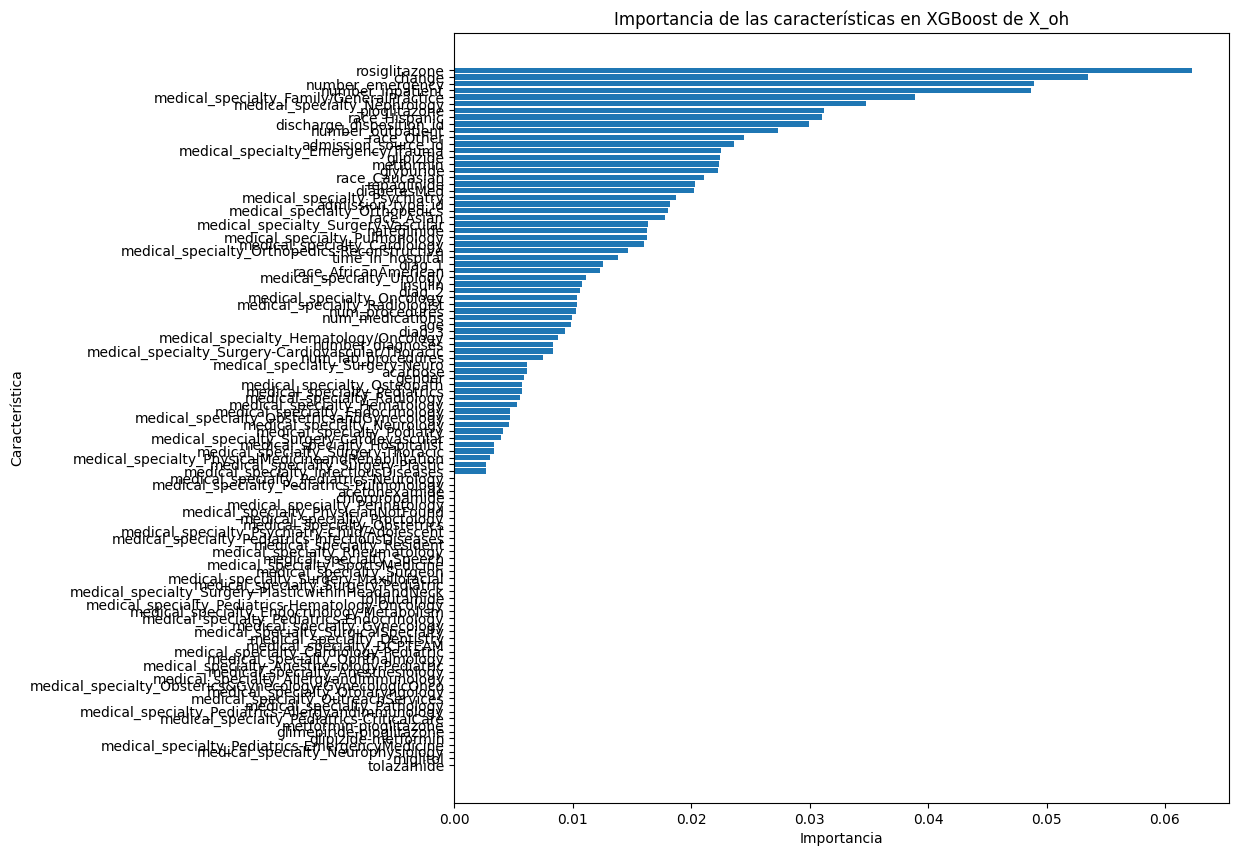

In [208]:
feature_importances_oh = best_xgb_oh.feature_importances_


feature_importance_df_oh = pd.DataFrame({
    'feature': X_oh_under_train.columns,
    'importance': feature_importances_oh
}).sort_values(by='importance', ascending=True)

print(feature_importance_df_oh.head(10))

plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df_oh['feature'], feature_importance_df_oh['importance'])
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.title("Importancia de las características en XGBoost de X_oh")
plt.show()


In [209]:
low_importance_features = feature_importance_df_oh.nsmallest(50, 'importance')['feature']

X_oh_train_reduced = X_oh_under_train.drop(columns=low_importance_features)
X_oh_test_reduced = X_oh_under_test.drop(columns=low_importance_features)

new_model_oh = XGBClassifier(**grid_search_xgb_oh.best_params_)
new_model_oh.fit(X_oh_train_reduced, y_under_train)

rendimiento(new_model_oh,X_oh_test_reduced,y_under_test)

Precisión del modelo: 0.6147839666840187

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.57      0.65      0.60      1896
           1       0.51      0.49      0.50      1939
           2       0.80      0.70      0.75      1928

    accuracy                           0.61      5763
   macro avg       0.62      0.62      0.62      5763
weighted avg       0.62      0.61      0.62      5763



0.6147839666840187

En esta parte aumentamos un 0.4%, obteniendo así el mejor resultado de todos.

## Conclusión

De este proyecto de Data Science podemos sacar varias conclusiones. En primer lugar, hemos tratado con unos datos de escasa calidad, no solo por valores faltantes, sino porque también hemos tenido que realizar una conversión de valores categóricos a numéricos, que se ha comlicado especialmente con medical_specialty. Para esta variable, hemos tenido que introducir ordinalidad o aumentar dimensionalidad con one-hot. Lo hemos hechod e las dos formas para comparar resultados, que han sido bastante parejos.

Además, nos encontramos con un problema de desequilibrio de clases, lo que nos llevó a explorar diversas técnicas de balanceo. Después de evaluar opciones como el oversampling y el uso de algoritmos que manejan imbalances, optamos por el undersampling.Aunque esta técnica reduce el tamaño del conjunto de datos, nos permitió obtener los mejores resultados en términos de rendimiento del modelo, especialmente en la identificación de las clases minoritarias. 

Para el modelo final, se ha optado por un XGBoost añadiendo búsqueda de hiperparámetros. Los mejores resultados en términos de recall (nuestra métrica prioritaria para minimizar falsos negativos) se obtuvieron utilizando los datos codificados con one-hot encoding y aplicando una reducción de dimensionalidad al eliminar las 55 características menos importantes. 

En resumen, este proyecto ha sido un ejercicio valioso de procesamiento de datos, donde nos hemos encontrados los mayores desafíos, así como de i la optimización de modelos para maximizar métricas específicas como el recall. Pasamos de una precisión del 56% y un recall de un 39% en media, a una precisión del 61,4% y un recall del 61,33%.